# use original rules of RuleFit instead of splitting them then do evaluation

In [1]:
import os, pickle, time, re, sys, operator

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import auc, classification_report, roc_auc_score, f1_score, matthews_corrcoef, balanced_accuracy_score, r2_score , confusion_matrix, precision_score, recall_score

import pandas as pd
import numpy as np
import seaborn as sns

from my_util import *
from lime.lime.lime_tabular import LimeTabularExplainer

# from pyexplainer.pyexplainer_pyexplainer import PyExplainer
import matplotlib.pyplot as plt


from datetime import datetime
from collections import Counter


sys.path.append(os.path.abspath('../'))
from pyexplainer.pyexplainer_pyexplainer import PyExplainer

from IPython.display import display

In [81]:
data_path = './dataset/'
# result_dir = './eval_result/'
result_dir = './new_eval_result/'
dump_dataframe_dir = './dump_df/'
pyExp_dir = './pyExplainer_obj/'
other_object_dir = './other_object/'
# proj_name = 'qt' # ['openstack','qt']

In [3]:
# def test_lime(proj_name):
#     global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
#     all_eval_result = pd.DataFrame()
    
#     for i in range(0,len(feature_df)):
#         X_explain = feature_df.iloc[[i]]

#         row_index = str(X_explain.index[0])

#         py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
#         lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

#         # this data can be used for both local and global model
#         py_exp_synthetic_data = py_exp['synthetic_data'].values
#         # this data can be used with global model only
#         lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
#         # this data can be used with local model only
#         lime_exp_synthetic_data_local = lime_exp['synthetic_instance_for_lobal_model']
        
#         display(X_explain)
#         display(lime_exp_synthetic_data[:5,:])
#         display(lime_exp_synthetic_data_local[:5,:])
        
#         break
        
# test_lime('openstack')

In [4]:
flip_sign_dict = {
    '<': '>=',
    '>': '<=',
    '=': '!=',
    '>=': '<',
    '<=': '>',
    '!=': '=='
}

'''
    input: rule (str)
'''
def flip_rule(rule):
    rule = re.sub(r'\b=\b',' = ',rule) # for LIME
#     rule = rule.replace('&','and') # for RuleFit
    found_rule = re.findall('.* <=? [a-zA-Z]+ <=? .*', rule) # for LIME
    ret = ''
    
    # for LIME that has condition like this: 0.53 < nref <= 0.83
    if len(found_rule) > 0:
        found_rule = found_rule[0]
    
        var_in_rule = re.findall('[a-zA-Z]+',found_rule)

        var_in_rule = var_in_rule[0]
        
        splitted_rule = found_rule.split(var_in_rule)
        splitted_rule[0] = splitted_rule[0] + var_in_rule # for left side
        splitted_rule[1] = var_in_rule + splitted_rule[1] # for right side
        combined_rule = splitted_rule[0] + ' or ' + splitted_rule[1]
        ret = flip_rule(combined_rule)
        
    else:
        for tok in rule.split():
            if tok in flip_sign_dict:
                ret = ret + flip_sign_dict[tok] + ' '
            else:
                ret = ret + tok + ' '
    return ret

def get_top_k_global_features(global_model, indep, top_k_global_feature_num = 5):
    global_feature_df = pd.DataFrame()
    global_feature_df['feature'] = indep
    global_feature_df['importance'] = global_model.feature_importances_

    global_feature_df = global_feature_df.sort_values(by='importance',ascending=False)

    top_k_global_features = list(global_feature_df['feature'])[:top_k_global_feature_num]

    return top_k_global_features
    
def sort_global_feature(global_model, indep):
    global_feature_df = pd.DataFrame()
    global_feature_df['feature'] = indep
    global_feature_df['importance'] = global_model.feature_importances_

    global_feature_df = global_feature_df.sort_values(by='importance',ascending=False)

    sorted_global_features = list(global_feature_df['feature'])

    return sorted_global_features

def get_rule_str_of_rulefit(local_rulefit_model):
    rule_df = local_rulefit_model.get_rules()
#     print(rule_df)
    top_k = 5
    top_k_positive_rules = rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("importance", ascending=False).head(top_k)
#     top_k_positive_rules = rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("coef", ascending=False).head(top_k)

    the_best_defective_rule_str = list(top_k_positive_rules['rule'])[0]
    
    return the_best_defective_rule_str

def get_rule_str_of_rulefit_new_version(local_rulefit_model):
    rule_df = local_rulefit_model.get_rules()
    rule_df =  rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("importance", ascending=False)
    
    rule_list = list(rule_df['rule'])
    dup_feature_in_rule = [] # true or false...
    
    for r in rule_list:
        var_in_rule = re.findall('[a-zA-Z]+', r)
        var_count = Counter(var_in_rule)
        max_count = max(list(var_count.values()))
        
        if max_count > 1:
            dup_feature_in_rule.append(True)
        else:
            dup_feature_in_rule.append(False)
           
    if False not in set(dup_feature_in_rule):
#         print('wtf')
        rule_df = rule_df.head(5)
        the_best_defective_rule_str = list(rule_df['rule'])[0]
        
    else:
        rule_df['contain_dup_var'] = dup_feature_in_rule    
        the_best_defective_rule_str = rule_df[rule_df['contain_dup_var']==False].iloc[0]['rule']
    
    return the_best_defective_rule_str

def aggregate_list(l):
    return np.mean(l), np.median(l)


In [4]:
# def test_new_rule_from_rulefit(proj_name):
#     global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
#     all_eval_result = pd.DataFrame()
    
#     c = 0
    
# #     py_exp_all_rules = []
# #     lime_all_rules = []
#     py_exp_all_vars = []
#     lime_all_vars = []
    
#     print('global feature feature importance ranking:')
#     print(sort_global_feature(global_model, indep))
#     for i in range(0,len(feature_df)):
#         X_explain = feature_df.iloc[[i]]

#         row_index = str(X_explain.index[0])

#         py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'_20_rules.pkl','rb'))
#         py_exp_local_model = py_exp['local_model']
        
#         lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))
        
# #         py_exp_rule = get_rule_str_of_rulefit(py_exp_local_model)
#         py_exp_rule_new = get_rule_str_of_rulefit_new_version(py_exp_local_model)
#         lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]

#         py_exp_pred = eval_rule(py_exp_rule_new, X_explain)[0]
#         lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

#         if py_exp_pred == 1:
#             py_exp_var_in_rule = list(set(re.findall('[a-zA-Z]+', py_exp_rule_new)))
#             py_exp_all_vars.extend(py_exp_var_in_rule)
#         if lime_pred == 1:
#             lime_var_in_rule = list(set(re.findall('[a-zA-Z]+', lime_the_best_defective_rule_str)))
#             lime_all_vars.extend(lime_var_in_rule)
            
# #         py_exp_all_rules.append(py_exp_rule_new)
# #         lime_all_rules.append(lime_the_best_defective_rule_str)
        
# #         eval_result = eval_rule(lime_the_best_defective_rule_str, X_explain)

# #         if eval_result[0]:
# #             c =c+1

    
# #     print(len(set(py_exp_all_rules)))
# #     print(len(set(lime_all_rules)))
    
#     print('pyExplainer var count')
#     print(Counter(py_exp_all_vars))
#     print('-'*100)
#     print('LIME var count')
#     print(Counter(lime_all_vars))
    
# print('openstack')
# test_new_rule_from_rulefit('openstack')
# print('*'*100)
# print('qt')
# test_new_rule_from_rulefit('qt')

In [5]:
def is_in_top_k_global_features(top_k_global_features, the_best_defective_rule_str):
    # remove numeric value
    new_the_best_defective_rule_str = re.sub('\d+','', the_best_defective_rule_str)

    # remove special characters
    new_the_best_defective_rule_str = re.sub('\W+',' ',new_the_best_defective_rule_str)
    splitted_rule = new_the_best_defective_rule_str.split()

    local_feature_count = 0
    
    found_features = set(splitted_rule).intersection(top_k_global_features)
    return list(found_features)

# def eval_rule(rule, X_explain):
#     var_in_rule = re.findall('[a-zA-Z]+',rule)
#     rule = rule.replace('&','and') # just for rulefit
#     rule = re.sub(r'\b=\b','==',rule)
# #             rule = rule.replace('=','==')

#     var_dict = {}

#     for var in var_in_rule:
#         var_dict[var] = float(X_explain[var])

#     eval_result = eval(rule,var_dict)
#     return eval_result

        
def prepare_data_for_testing(proj_name, global_model_name = 'RF'):
    global_model_name = global_model_name.upper()
    global_model = pickle.load(open(proj_name+'_'+global_model_name+'_global_model.pkl','rb'))

    correctly_predict_df = pd.read_csv(dump_dataframe_dir+proj_name+'_'+global_model_name+'_correctly_predict_as_defective.csv')
    correctly_predict_df = correctly_predict_df.set_index('commit_id')

    dep = 'defect'
    indep = correctly_predict_df.columns[:-3] # exclude the last 3 columns

    feature_df = correctly_predict_df.loc[:, indep]
    
    return global_model, correctly_predict_df, indep, dep, feature_df
    

# Global model evaluation

In [6]:
def get_prediction_result_df(proj_name, global_model_name):
    global_model_name = global_model_name.upper()
    if global_model_name not in ['RF','LR']:
        print('wrong global model name. the global model name must be RF or LR')
        return
    
    prediction_df_dir = dump_dataframe_dir+proj_name+'_'+global_model_name+'_prediction_result.csv'
    correctly_predict_df_dir = dump_dataframe_dir+proj_name+'_'+global_model_name+'_correctly_predict_as_defective.csv'
    
    if not os.path.exists(prediction_df_dir) or not os.path.exists(correctly_predict_df_dir):
        global_model = pickle.load(open(proj_name+'_'+global_model_name+'_global_model.pkl','rb'))

        pred = global_model.predict(x_test)
        defective_prob = global_model.predict_proba(x_test)[:,1]

        prediction_df = x_test.copy()
        prediction_df['pred'] = pred
        prediction_df['defective_prob'] = defective_prob
        prediction_df['defect'] = y_test

    #     print('AUC is',roc_auc_score(y_test, defective_prob))
        correctly_predict_df = prediction_df[(prediction_df['pred']==1) & (prediction_df['defect']==1)]

        print('total correct prediction: {}'.format(str(len(correctly_predict_df))))

        prediction_df.to_csv(prediction_df_dir)
        correctly_predict_df.to_csv(correctly_predict_df_dir)
    
    else:
        prediction_df = pd.read_csv(prediction_df_dir)
        correctly_predict_df = pd.read_csv(correctly_predict_df_dir)
        
        prediction_df = prediction_df.set_index('commit_id')
        correctly_predict_df = correctly_predict_df.set_index('commit_id')
        print('total correct prediction: {}'.format(str(len(correctly_predict_df))))
        
    return prediction_df, correctly_predict_df

def get_recall_at_k_percent_effort(percent_effort, result_df_arg, real_buggy_commits):
    cum_LOC_k_percent = (percent_effort/100)*result_df_arg.iloc[-1]['cum_LOC']
    buggy_line_k_percent =  result_df_arg[result_df_arg['cum_LOC'] <= cum_LOC_k_percent]
    buggy_commit = buggy_line_k_percent[buggy_line_k_percent['defect']==True]
    recall_k_percent_effort = len(buggy_commit)/float(len(real_buggy_commits))
    
    return recall_k_percent_effort

def eval_global_model(proj_name, prediction_df):
    ## since ld metric in openstack is removed by using autospearman, so this code is needed
    ## but this is not problem for qt
    
    if proj_name == 'openstack':
        x_train_original, x_test_original = prepare_data_all_metrics(proj_name, mode='all')
        prediction_df = prediction_df.copy()
#         print('add ld')
#         display(x_test_original['ld'])
        prediction_df['ld'] = list(x_test_original['ld'])
        
    prediction_df = prediction_df[['la','ld', 'pred', 'defective_prob' ,'defect']]
    prediction_df['LOC'] = prediction_df['la']+prediction_df['ld']
    
    
#     result_df['defect_density'] = result_df['defective_commit_prob']/result_df['LOC']
    prediction_df['defect_density'] = prediction_df['defective_prob']/prediction_df['LOC']
    prediction_df['actual_defect_density'] = prediction_df['defect']/prediction_df['LOC'] #defect density
    
    prediction_df = prediction_df.fillna(0)
    prediction_df = prediction_df.replace(np.inf, 0)
    
    prediction_df = prediction_df.sort_values(by='defect_density',ascending=False)
#     display(prediction_df.head())
#     display(np.sum(prediction_df[prediction_df['la']==0]['defect']))
    
    actual_result_df = prediction_df.sort_values(by='actual_defect_density',ascending=False)
    actual_worst_result_df = prediction_df.sort_values(by='actual_defect_density',ascending=True)

    prediction_df['cum_LOC'] = prediction_df['LOC'].cumsum()
    actual_result_df['cum_LOC'] = actual_result_df['LOC'].cumsum()
    actual_worst_result_df['cum_LOC'] = actual_worst_result_df['LOC'].cumsum()

    real_buggy_commits = prediction_df[prediction_df['defect'] == True]
    
#     display(prediction_df)
#     display(real_buggy_commits)
    
    
    AUC = roc_auc_score(prediction_df['defect'], prediction_df['defective_prob'])
    f1 = f1_score(prediction_df['defect'], prediction_df['pred'])
    
    ifa = real_buggy_commits.iloc[0]['cum_LOC']
#     print('ifa:',ifa)

    cum_LOC_20_percent = 0.2*prediction_df.iloc[-1]['cum_LOC']
    buggy_line_20_percent = prediction_df[prediction_df['cum_LOC'] <= cum_LOC_20_percent]
    buggy_commit = buggy_line_20_percent[buggy_line_20_percent['defect']==True]
    recall_20_percent_effort = len(buggy_commit)/float(len(real_buggy_commits))
    
    # find P_opt
    percent_effort_list = []
    predicted_recall_at_percent_effort_list = []
    actual_recall_at_percent_effort_list = []
    actual_worst_recall_at_percent_effort_list = []
    
    for percent_effort in np.arange(10,101,10):
        predicted_recall_k_percent_effort = get_recall_at_k_percent_effort(percent_effort, prediction_df, real_buggy_commits)
        actual_recall_k_percent_effort = get_recall_at_k_percent_effort(percent_effort, actual_result_df, real_buggy_commits)
        actual_worst_recall_k_percent_effort = get_recall_at_k_percent_effort(percent_effort, actual_worst_result_df, real_buggy_commits)
        
        percent_effort_list.append(percent_effort/100)
        
        predicted_recall_at_percent_effort_list.append(predicted_recall_k_percent_effort)
        actual_recall_at_percent_effort_list.append(actual_recall_k_percent_effort)
        actual_worst_recall_at_percent_effort_list.append(actual_worst_recall_k_percent_effort)

    p_opt = 1 - ((auc(percent_effort_list, actual_recall_at_percent_effort_list) - 
                 auc(percent_effort_list, predicted_recall_at_percent_effort_list)) /
                (auc(percent_effort_list, actual_recall_at_percent_effort_list) -
                auc(percent_effort_list, actual_worst_recall_at_percent_effort_list)))

    print('AUC: {}, F1: {}, IFA: {}, Recall@20%Effort: {}, Popt: {}'.format(AUC,f1,ifa,recall_20_percent_effort,p_opt))
    print(classification_report(prediction_df['defect'], prediction_df['pred']))
#     display(cum_LOC_20_percent)
#     display(buggy_line_20_percent)
# #     display(cum_LOC_20_percent)
#     display(buggy_commit)
#     print(len(real_buggy_commits))
#     display(recall_20_percent_effort)

def get_global_model_evaluation_result(proj_name):
    print('RF global model result')
    rf_prediction_df, rf_correctly_predict_df = get_prediction_result_df(proj_name, 'rf')
    eval_global_model(proj_name, rf_prediction_df)

    print('-'*100)
    
    print('LR global model result')
    lr_prediction_df, lr_correctly_predict_df = get_prediction_result_df(proj_name, 'lr')
    eval_global_model(proj_name, lr_prediction_df)

In [18]:
get_global_model_evaluation_result('openstack')

RF global model result
total correct prediction: 198
AUC: 0.7468482561455155, F1: 0.35515695067264574, IFA: 244, Recall@20%Effort: 0.5619195046439629, Popt: 0.8247763516141581
              precision    recall  f1-score   support

       False       0.87      0.92      0.89      3317
        True       0.42      0.31      0.36       646

    accuracy                           0.82      3963
   macro avg       0.65      0.61      0.62      3963
weighted avg       0.80      0.82      0.81      3963

----------------------------------------------------------------------------------------------------
LR global model result
total correct prediction: 376
AUC: 0.6641828240110286, F1: 0.3550519357884797, IFA: 39, Recall@20%Effort: 0.5386996904024768, Popt: 0.8251993000194437
              precision    recall  f1-score   support

       False       0.89      0.67      0.76      3317
        True       0.26      0.58      0.36       646

    accuracy                           0.66      3963
   m

In [19]:
get_global_model_evaluation_result('qt')

RF global model result
total correct prediction: 79
AUC: 0.7350656132213174, F1: 0.20954907161803715, IFA: 19, Recall@20%Effort: 0.8340336134453782, Popt: 0.9434782608695651
              precision    recall  f1-score   support

       False       0.95      0.97      0.96      7801
        True       0.28      0.17      0.21       476

    accuracy                           0.93      8277
   macro avg       0.62      0.57      0.59      8277
weighted avg       0.91      0.93      0.92      8277

----------------------------------------------------------------------------------------------------
LR global model result
total correct prediction: 255
AUC: 0.6445637221687803, F1: 0.15877957658779576, IFA: 7, Recall@20%Effort: 0.8172268907563025, Popt: 0.9454658385093166
              precision    recall  f1-score   support

       False       0.96      0.68      0.80      7801
        True       0.09      0.54      0.16       476

    accuracy                           0.67      8277
   mac

<ipython-input-17-a087943c281d>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['LOC'] = prediction_df['la']+prediction_df['ld']
<ipython-input-17-a087943c281d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['defect_density'] = prediction_df['defective_prob']/prediction_df['LOC']
<ipython-input-17-a087943c281d>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

# RQ1 evaluation

In [98]:
# def check_LIME_generated_instances(proj_name, global_model_name):
#     global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name)
#     all_eval_result = pd.DataFrame()
    
#     for i in range(0,len(feature_df)):
#         X_explain = feature_df.iloc[[i]]

#         row_index = str(X_explain.index[0])
#         lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

#         # this data can be used with global model only
#         lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
        
#         lime_exp_local_model = lime_exp['local_model']


#         lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
# #         lime_exp_local_pred = np.round(lime_exp_local_pred)

#         total_defect =  np.sum(lime_exp_global_pred)
#         total_inst = len(lime_exp_global_pred)
#         lime_exp_def_pred_ratio = total_defect/total_inst

#         print(total_defect, total_inst, lime_exp_def_pred_ratio)
# #         print(np.sum(py_exp_global_pred), len(py_exp_global_pred), np.sum(lime_exp_global_pred), len(lime_exp_global_pred))
# #         py_exp_serie = pd.Series(data=[proj_name, row_index, 'pyExplainer',
# #                                        py_exp_dist_med, py_exp_def_pred_ratio])
# #         lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
# #                                          lime_exp_dist_med, lime_exp_def_pred_ratio])
        
# #         all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
# #         all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)

In [20]:
# check_LIME_generated_instances('openstack')

In [21]:
# check_LIME_generated_instances('qt')

In [22]:
def rq1_eval(proj_name, global_model_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name)
    all_eval_result = pd.DataFrame()
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        exp_obj = pickle.load(open(pyExp_dir+proj_name+'_'+global_model_name+'_all_explainer_'+row_index+'.pkl','rb'))
        py_exp = exp_obj['pyExplainer']
        lime_exp = exp_obj['LIME']

        # this data can be used for both local and global model
        py_exp_synthetic_data = py_exp['synthetic_data'].values
        # this data can be used with global model only
        lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
        
        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']

        py_exp_global_pred = global_model.predict(py_exp_synthetic_data)

        lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
#         lime_exp_local_pred = np.round(lime_exp_local_pred)

        py_exp_dist = euclidean_distances(X_explain.values, py_exp_synthetic_data)
        lime_dist = euclidean_distances(X_explain.values, lime_exp_synthetic_data)

        py_exp_dist_mean, py_exp_dist_med = aggregate_list(py_exp_dist)
        lime_exp_dist_mean, lime_exp_dist_med = aggregate_list(lime_dist)

        py_exp_def_pred_ratio = np.sum(py_exp_global_pred)/len(py_exp_global_pred)
        lime_exp_def_pred_ratio = np.sum(lime_exp_global_pred)/len(lime_exp_global_pred)

#         print(np.sum(py_exp_global_pred), len(py_exp_global_pred), np.sum(lime_exp_global_pred), len(lime_exp_global_pred))
        py_exp_serie = pd.Series(data=[proj_name, row_index, 'pyExplainer',
                                       py_exp_dist_med, py_exp_def_pred_ratio])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                         lime_exp_dist_med, lime_exp_def_pred_ratio])
        
        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)
        
#         print(py_exp_def_pred_ratio, lime_exp_def_pred_ratio)
#         break
    all_eval_result.columns =['project', 'commit id', 'method', 'euc_dist_med', 'defective_generated_instance_ratio']
    
# # #     display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ1_'+proj_name+'_'+global_model_name+'.csv',index=False)
    print('finished RQ1 of',proj_name,', globla model is',global_model_name)
    
# rq1_eval('openstack') 

In [24]:
rq1_eval('openstack', 'RF')
rq1_eval('qt', 'RF')

finished RQ1 of openstack , globla model is RF
finished RQ1 of qt , globla model is RF


In [25]:
rq1_eval('openstack', 'LR')
rq1_eval('qt', 'LR')

finished RQ1 of openstack , globla model is LR
finished RQ1 of qt , globla model is LR


In [223]:
def show_rq1_eval_result():
    openstack_rf = pd.read_csv('./eval_result/RQ1_openstack_RF.csv')
    qt_rf = pd.read_csv('./eval_result/RQ1_qt_RF.csv')
    result_rf = pd.concat([openstack_rf, qt_rf])
    result_rf['global_model'] = 'RF'
    
    openstack_lr = pd.read_csv('./eval_result/RQ1_openstack_LR.csv')
    qt_lr = pd.read_csv('./eval_result/RQ1_qt_LR.csv')
    result_lr = pd.concat([openstack_lr, qt_lr])
    result_lr['global_model'] = 'LR'
    
    all_result = pd.concat([result_rf, result_lr])

    fig, axs = plt.subplots(1,2, figsize=(10,6))

    axs[0].set_title('RF')
    axs[1].set_title('LR')
    
    axs[0].set(ylim=(0, 5000))
#     axs[1,0].set(ylim=(0, 1))
    axs[1].set(ylim=(0, 5000))
#     axs[1,1].set(ylim=(0, 1))
    
#     plt.ylim(0,5000)
    sns.boxplot(data=result_rf, x='project', y='euc_dist_med', hue='method', ax=axs[0])
#     plt.ylim(0,1)
#     sns.boxplot(data=result_rf, x='project', y='defective_generated_instance_ratio', hue='method', ax=axs[1,0])
#     plt.ylim(0,5000)
    sns.boxplot(data=result_lr, x='project', y='euc_dist_med', hue='method', ax=axs[1])
#     plt.ylim(0,1)
#     sns.boxplot(data=result_lr, x='project', y='defective_generated_instance_ratio', hue='method', ax=axs[1,1])
    
    plt.show()

    display(all_result.groupby(['global_model', 'project', 'method']).describe())
    
    result_rf.to_csv('./eval_result/RQ1_RF.csv',index=False)
    result_lr.to_csv('./eval_result/RQ1_LR.csv',index=False)
    all_result.to_csv('./eval_result/RQ1.csv',index=False)
    
    fig.savefig('./eval_result/figures/RQ1.png')
    
#     display(all_result)

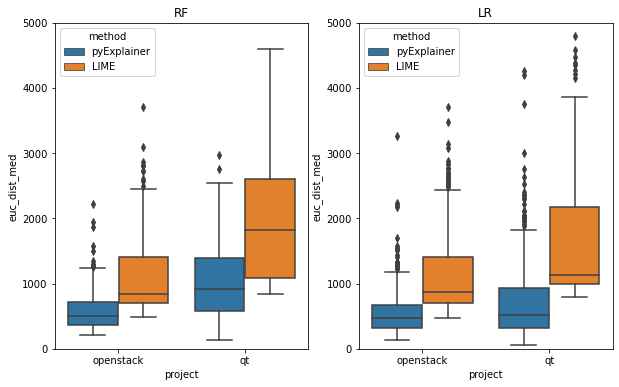

euc_dist_med                            \
                                          count         mean          std   
global_model project   method                                               
LR           openstack LIME               376.0  1131.262558   618.026586   
                       pyExplainer        376.0   557.807385   362.146216   
             qt        LIME               255.0  1710.479949  1179.979075   
                       pyExplainer        255.0   811.010560  1017.593081   
RF           openstack LIME               198.0  1127.613198   623.720753   
                       pyExplainer        198.0   591.730160   336.210659   
             qt        LIME                79.0  1981.142021   992.506462   
                       pyExplainer         79.0  1073.430037   658.951800   

                                                                          \
                                           min          25%          50%   
global_model project   method                                              
LR           openstack LIME         477.756571   701.172394   870.391645   
                       pyExplainer  138.915781   312.663098   464.889745   
             qt        LIME         793.941497   991.287738  1138.732355   
                       pyExplainer   56.939860   319.096248   519.294034   
RF           openstack LIME         480.403424   706.994530   841.419710   
                       pyExplainer  208.965221   363.540465   499.514998   
             qt        LIME         841.474520  1082.522918  1825.047204   
                       pyExplainer  142.504855   586.150375   923.460322   

                                                               \
                                            75%           max   
global_model project   method                                   
LR           openstack LIME         1406.863042   3714.300936   
                       pyExplainer   668.952822   3265.423908   
             qt        LIME         2175.935989  13066.498777   
                       pyExplainer   939.178532  12696.966184   
RF           openstack LIME         1413.531171   3706.934900   
                       pyExplainer   718.352814   2221.477801   
             qt        LIME         2603.049893   4588.606492   
                       pyExplainer  1386.965269   2972.080245   

                                   defective_generated_instance_ratio  \
                                                                count   
global_model project   method                                           
LR           openstack LIME                                     376.0   
                       pyExplainer                              376.0   
             qt        LIME                                     255.0   
                       pyExplainer                              255.0   
RF           openstack LIME                                     198.0   
                       pyExplainer                              198.0   
             qt        LIME                                      79.0   
                       pyExplainer                               79.0   

                                                                            \
                                        mean       std       min       25%   
global_model project   method                                                
LR           openstack LIME         0.597434  0.006264  0.576400  0.593000   
                       pyExplainer  0.687295  0.167879  0.170982  0.591065   
             qt        LIME         0.596206  0.006805  0.572800  0.591800   
                       pyExplainer  0.716454  0.169285  0.183036  0.635175   
RF           openstack LIME         0.165280  0.004570  0.154600  0.161850   
                       pyExplainer  0.560800  0.094219  0.203125  0.496987   
             qt        LIME         0.135856  0.004667  0.123000  0.133100   
                       pyExplainer  0.485236  0.05

In [224]:
show_rq1_eval_result()

,project,commit id,method,euc_dist_med,defective_generated_instance_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,pyExplainer,349.245008,0.454018
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,539.434323,0.169000
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,pyExplainer,498.606153,0.713060
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,1400.589845,0.166800
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,pyExplainer,233.375005,0.544196


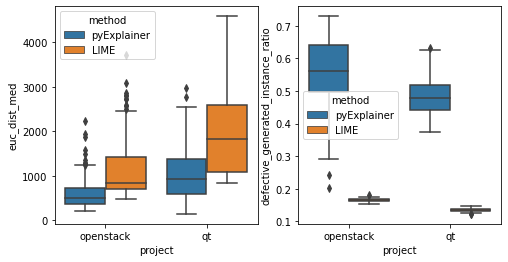

euc_dist_med                                       \
                             count         mean         std         min   
project   method                                                          
openstack LIME               198.0  1127.613198  623.720753  480.403424   
          pyExplainer        198.0   591.730160  336.210659  208.965221   
qt        LIME                79.0  1981.142021  992.506462  841.474520   
          pyExplainer         79.0  1073.430037  658.951800  142.504855   

                                                                           \
                               25%          50%          75%          max   
project   method                                                            
openstack LIME          706.994530   841.419710  1413.531171  3706.934900   
          pyExplainer   363.540465   499.514998   718.352814  2221.477801   
qt        LIME         1082.522918  1825.047204  2603.049893  4588.606492   
          pyExplainer   586.150375   923.460322  1386.965269  2972.080245   

                      defective_generated_instance_ratio                      \
                                                   count      mean       std   
project   method                                                               
openstack LIME                                     198.0  0.165280  0.004570   
          pyExplainer                              198.0  0.560800  0.094219   
qt        LIME                                      79.0  0.135856  0.004667   
          pyExplainer                               79.0  0.485236  0.058970   

                                                                         
                            min       25%       50%       75%       max  
project   method                                                         
openstack LIME         0.154600  0.161850  0.165200  0.168400  0.180800  
          pyExplainer  0.203125  0.496987  0.560373  0.641589  0.729038  
qt        LIME         0.123000  0.133100  0.136200  0.139000  0.147400  
          pyExplainer  0.375446  0.442857  0.479464  0.517931  0.630601

In [47]:
show_rq1_eval_result('rf')

,project,commit id,method,euc_dist_med,defective_generated_instance_ratio
0,openstack,71f2184c617123b90f8e911056f23e3346c7c592,pyExplainer,201.826099,0.558753
1,openstack,71f2184c617123b90f8e911056f23e3346c7c592,LIME,517.262852,0.595600
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,pyExplainer,594.107640,0.855357
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,1393.158004,0.586400
4,openstack,ef8017ff798c2a1bc548af6f0356b1aab3cfb0e2,pyExplainer,297.858818,0.779392


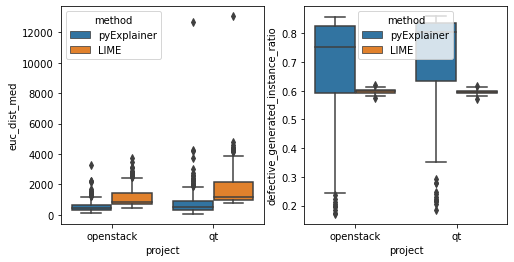

euc_dist_med                                        \
                             count         mean          std         min   
project   method                                                           
openstack LIME               376.0  1131.262558   618.026586  477.756571   
          pyExplainer        376.0   557.807385   362.146216  138.915781   
qt        LIME               255.0  1710.479949  1179.979075  793.941497   
          pyExplainer        255.0   811.010560  1017.593081   56.939860   

                                                                           \
                              25%          50%          75%           max   
project   method                                                            
openstack LIME         701.172394   870.391645  1406.863042   3714.300936   
          pyExplainer  312.663098   464.889745   668.952822   3265.423908   
qt        LIME         991.287738  1138.732355  2175.935989  13066.498777   
          pyExplainer  319.096248   519.294034   939.178532  12696.966184   

                      defective_generated_instance_ratio                      \
                                                   count      mean       std   
project   method                                                               
openstack LIME                                     376.0  0.597434  0.006264   
          pyExplainer                              376.0  0.687295  0.167879   
qt        LIME                                     255.0  0.596206  0.006805   
          pyExplainer                              255.0  0.716454  0.169285   

                                                                         
                            min       25%       50%       75%       max  
project   method                                                         
openstack LIME         0.576400  0.593000  0.597400  0.602400  0.620000  
          pyExplainer  0.170982  0.591065  0.750934  0.824219  0.855357  
qt        LIME         0.572800  0.591800  0.596400  0.600600  0.616800  
          pyExplainer  0.183036  0.635175  0.804464  0.835268  0.859375

In [48]:
show_rq1_eval_result('lr')

# RQ2 evaluation

In [29]:
# def check_pyExp_prediction(proj_name,global_model_name):
#     global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name,global_model_name)
#     all_eval_result = pd.DataFrame()

#     for i in range(0,len(feature_df)):
#         X_explain = feature_df.iloc[[i]]

#         row_index = str(X_explain.index[0])

#         py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
#         # this data can be used for both local and global model
#         py_exp_synthetic_data = py_exp['synthetic_data'].values
#         py_exp_local_model = py_exp['local_model']
#         py_exp_global_pred = global_model.predict(py_exp_synthetic_data) 
#         py_exp_local_prob = py_exp_local_model.predict_proba(py_exp_synthetic_data)[:,1]
#         py_exp_local_pred = py_exp_local_model.predict(py_exp_synthetic_data)
        
#         tn, fp, fn, tp = confusion_matrix(py_exp_global_pred, py_exp_local_pred).ravel()
        
#         print('total prediction:',len(py_exp_global_pred))
#         print('TN:',tn,'FP:', fp,'FN:', fn,'TP:', tp)
# #         py_exp_local_pred = [1 if val else 0 for val in py_exp_local_pred]

# #         pred_df = pd.DataFrame()
# #         pred_df['label'] = py_exp_global_pred
# #         pred_df['prob'] = py_exp_local_prob
# #         pred_df['pred'] = py_exp_local_pred
        
# #         true_pred_df = pred_df[pred_df['label']==True]
# #         print('total prediction:',len(pred_df))
# #         print('total global correct prediction:', len(true_pred_df))
# #         display(true_pred_df)
        
#         print('-'*100)
        
#         if i > 10:
#             break
# #         py_exp_auc = roc_auc_score(py_exp_global_pred, py_exp_local_prob)
# #         py_exp_f1 = f1_score(py_exp_global_pred, py_exp_local_pred)
# #         py_exp_mcc = matthews_corrcoef(py_exp_global_pred, py_exp_local_pred)
# #         py_exp_bal_acc = balanced_accuracy_score(py_exp_global_pred, py_exp_local_pred)
        
        
    

In [110]:
# check_pyExp_prediction('openstack')

total prediction: 2240
TN: 1166 FP: 48 FN: 70 TP: 956
----------------------------------------------------------------------------------------------------
total prediction: 2098
TN: 578 FP: 15 FN: 3 TP: 1502
----------------------------------------------------------------------------------------------------
total prediction: 2240
TN: 1005 FP: 51 FN: 73 TP: 1111
----------------------------------------------------------------------------------------------------
total prediction: 2213
TN: 987 FP: 76 FN: 51 TP: 1099
----------------------------------------------------------------------------------------------------
total prediction: 2124
TN: 760 FP: 41 FN: 22 TP: 1301
----------------------------------------------------------------------------------------------------
total prediction: 2189
TN: 788 FP: 71 FN: 60 TP: 1270
----------------------------------------------------------------------------------------------------
total prediction: 2217
TN: 916 FP: 19 FN: 18 TP: 1264
----------------

In [111]:
# check_pyExp_prediction('qt')

total prediction: 2186
TN: 1204 FP: 24 FN: 22 TP: 936
----------------------------------------------------------------------------------------------------
total prediction: 2240
TN: 1127 FP: 20 FN: 21 TP: 1072
----------------------------------------------------------------------------------------------------
total prediction: 2207
TN: 1190 FP: 17 FN: 16 TP: 984
----------------------------------------------------------------------------------------------------
total prediction: 2152
TN: 1041 FP: 27 FN: 18 TP: 1066
----------------------------------------------------------------------------------------------------
total prediction: 2092
TN: 797 FP: 48 FN: 38 TP: 1209
----------------------------------------------------------------------------------------------------
total prediction: 2193
TN: 1078 FP: 17 FN: 15 TP: 1083
----------------------------------------------------------------------------------------------------
total prediction: 2240
TN: 1127 FP: 16 FN: 22 TP: 1075
------------

In [240]:
def rq2_eval(proj_name, global_model_name):
    global_model_name = global_model_name.upper()
    
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name)
    all_eval_result = pd.DataFrame()

#     pyexp_pred_df = pd.DataFrame()
#     lime_pred_df = pd.DataFrame()
    
    pyexp_label, pyexp_prob = [],[]
    lime_label, lime_prob = [],[]
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        exp_obj = pickle.load(open(pyExp_dir+proj_name+'_'+global_model_name+'_all_explainer_'+row_index+'.pkl','rb'))
        py_exp = exp_obj['pyExplainer']
        lime_exp = exp_obj['LIME']

        # this data can be used for both local and global model
        py_exp_synthetic_data = py_exp['synthetic_data'].values
        # this data can be used with global model only
        lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
        # this data can be used with local model only
        lime_exp_synthetic_data_local = lime_exp['synthetic_instance_for_lobal_model']
        
        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']

        py_exp_global_pred = global_model.predict(py_exp_synthetic_data) 
        py_exp_local_prob = py_exp_local_model.predict_proba(py_exp_synthetic_data)[:,1]
        py_exp_local_pred = py_exp_local_model.predict(py_exp_synthetic_data)
#         py_exp_local_pred = [1 if val else 0 for val in py_exp_local_pred]

        lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
        lime_exp_local_prob = lime_exp_local_model.predict(lime_exp_synthetic_data_local)
        lime_exp_local_pred = np.round(lime_exp_local_prob)
        
        pyexp_label.extend(list(py_exp_global_pred))
        pyexp_prob.extend(list(py_exp_local_prob))
        
        lime_label.extend(list(lime_exp_global_pred))
        lime_prob.extend(list(lime_exp_local_prob))
        
        
        py_exp_auc = roc_auc_score(py_exp_global_pred, py_exp_local_prob)
        py_exp_f1 = f1_score(py_exp_global_pred, py_exp_local_pred)
#         py_exp_mcc = matthews_corrcoef(py_exp_global_pred, py_exp_local_pred)
#         py_exp_bal_acc = balanced_accuracy_score(py_exp_global_pred, py_exp_local_pred)
        
        lime_auc = roc_auc_score(lime_exp_global_pred, lime_exp_local_prob)
        lime_f1 = f1_score(lime_exp_global_pred, lime_exp_local_pred)
#         lime_mcc = matthews_corrcoef(lime_exp_global_pred, lime_exp_local_pred)
#         lime_bal_acc = balanced_accuracy_score(lime_exp_global_pred, lime_exp_local_pred)

        py_exp_serie = pd.Series(data=[proj_name, row_index, 'pyExplainer',
                                        py_exp_auc, py_exp_f1])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                           lime_auc, lime_f1])
        
        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)
        
#         break

    pred_df = pd.DataFrame()
    
    all_tech = ['pyExplainer']*len(pyexp_label) + ['LIME']*len(lime_label)
    
    pred_df['technique'] = all_tech
    pred_df['label'] = pyexp_label+lime_label
    pred_df['prob'] = pyexp_prob+lime_prob
    pred_df['project'] = proj_name
    
    all_eval_result.columns = ['project', 'commit id', 'method', 'AUC', 'F1']

#     display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ2_'+proj_name+'_'+global_model_name+'_global_vs_local_synt_pred.csv',index=False)
    pred_df.to_csv(result_dir+'RQ2_'+proj_name+'_'+global_model_name+'_probability_distribution.csv',index=False)
    print('finished RQ2 of',proj_name)

In [241]:
rq2_eval('openstack','RF')
rq2_eval('qt','RF')

finished RQ2 of openstack
finished RQ2 of qt


In [242]:
rq2_eval('openstack','lr')
rq2_eval('qt','lr')

finished RQ2 of openstack
finished RQ2 of qt


In [232]:
def show_rq2_eval_result():
    openstack_rf = pd.read_csv('./eval_result/RQ2_openstack_RF_global_vs_local_synt_pred.csv')
    qt_rf = pd.read_csv('./eval_result/RQ2_qt_RF_global_vs_local_synt_pred.csv')
    result_rf = pd.concat([openstack_rf, qt_rf])
    result_rf['global_model'] = 'RF'
    
    openstack_lr = pd.read_csv('./eval_result/RQ2_openstack_LR_global_vs_local_synt_pred.csv')
    qt_lr = pd.read_csv('./eval_result/RQ2_qt_LR_global_vs_local_synt_pred.csv')
    result_lr = pd.concat([openstack_lr, qt_lr])
    result_lr['global_model'] = 'LR'
    
    all_result = pd.concat([result_rf, result_lr])

    fig, axs = plt.subplots(2,2, figsize=(10,10))

    axs[0,0].set_title('RF')
    axs[0,1].set_title('LR')
    
    axs[0,0].set_ylim([0, 1])
    axs[0,1].set_ylim([0, 1]) 
    axs[1,0].set_ylim([0, 1])
    axs[1,1].set_ylim([0, 1])

    sns.boxplot(data=result_rf, x='project', y='AUC', hue='method', ax=axs[0,0])
    sns.boxplot(data=result_rf, x='project', y='F1', hue='method', ax=axs[1,0])
    sns.boxplot(data=result_lr, x='project', y='AUC', hue='method', ax=axs[0,1])
    sns.boxplot(data=result_lr, x='project', y='F1', hue='method', ax=axs[1,1])


    plt.show()

    pd.set_option("max_columns", 40)
    display(all_result.groupby(['global_model', 'project','method']).describe())
    
    result_rf.to_csv('./eval_result/RQ2_RF_prediction.csv',index=False)
    result_lr.to_csv('./eval_result/RQ2_LR_prediction.csv',index=False)
    all_result.to_csv('./eval_result/RQ2_prediction.csv',index=False)
    
    fig.savefig('./eval_result/figures/RQ2_prediction.png')
#     print('openstack result')
#     display(openstack_result_df.groupby('method').describe())
#     print('qt result')
#     display(qt_result_df.groupby('method').describe())

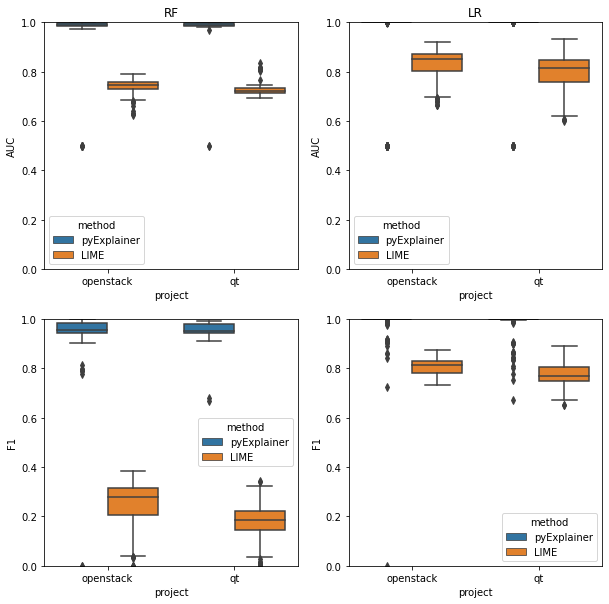

AUC                                \
                                    count      mean       std       min   
global_model project   method                                             
LR           openstack LIME         376.0  0.829845  0.054818  0.665162   
                       pyExplainer  376.0  0.965342  0.127000  0.500000   
             qt        LIME         255.0  0.799339  0.073578  0.599662   
                       pyExplainer  255.0  0.962703  0.131546  0.500000   
RF           openstack LIME         198.0  0.739566  0.029421  0.623621   
                       pyExplainer  198.0  0.970641  0.097037  0.500000   
             qt        LIME          79.0  0.728769  0.031849  0.693537   
                       pyExplainer   79.0  0.978399  0.077853  0.500000   

                                                                            \
                                         25%       50%       75%       max   
global_model project   method                                                
LR           openstack LIME         0.801032  0.849540  0.871259  0.918184   
                       pyExplainer  0.999999  1.000000  1.000000  1.000000   
             qt        LIME         0.756315  0.815708  0.847866  0.932132   
                       pyExplainer  0.999942  1.000000  1.000000  1.000000   
RF           openstack LIME         0.727860  0.746571  0.757864  0.791661   
                       pyExplainer  0.984893  0.987770  0.997650  1.000000   
             qt        LIME         0.712514  0.720373  0.732195  0.835871   
                       pyExplainer  0.986425  0.989037  0.997969  0.999191   

                                       F1                                \
                                    count      mean       std       min   
global_model project   method                                             
LR           openstack LIME         376.0  0.805110  0.030884  0.732030   
                       pyExplainer  376.0  0.988979  0.058272  0.000000   
             qt        LIME         255.0  0.775945  0.045094  0.650254   
                       pyExplainer  255.0  0.987397  0.044310  0.671770   
RF           openstack LIME         198.0  0.249181  0.087802  0.000000   
                       pyExplainer  198.0  0.944699  0.102566  0.000000   
             qt        LIME          79.0  0.168112  0.088696  0.000000   
                       pyExplainer   79.0  0.948696  0.049454  0.667460   

                                                                            
                                         25%       50%       75%       max  
global_model project   method                                               
LR           openstack LIME         0.780089  0.811333  0.830309  0.875282  
                       pyExplainer  0.999201  1.000000  1.000000  1.000000  
             qt        LIME         0.746965  0.767388  0.804211  0.889723  
                       pyExplainer  0.998394  1.000000  1.000000  1.000000  
RF           openstack LIME         0.203805  0.277810  0.314145  0.385425  
                       pyExplainer  0.941006  0.955757  0.981835  1.000000  
             qt        LIME         0.145653  0.185090  0.220874  0.344488  
                       pyExplainer  0.940376  0.951140  0.979230  0.988722

In [233]:
show_rq2_eval_result()

In [18]:
def show_rq2_prob_distribution():
    
    d = {True: 'DEFECT', False: 'CLEAN'}


    openstack_rf = pd.read_csv('./eval_result/RQ2_openstack_RF_probability_distribution.csv')
    qt_rf = pd.read_csv('./eval_result/RQ2_qt_RF_probability_distribution.csv')
    
    mask = openstack_rf.applymap(type) != bool
    openstack_rf = openstack_rf.where(mask, openstack_rf.replace(d))
    qt_rf = qt_rf.where(mask, qt_rf.replace(d))
    
    result_rf = pd.concat([openstack_rf, qt_rf])
    result_rf['global_model'] = 'RF'
    
    openstack_lr = pd.read_csv('./eval_result/RQ2_openstack_LR_probability_distribution.csv')
    qt_lr = pd.read_csv('./eval_result/RQ2_qt_LR_probability_distribution.csv')
    
    openstack_lr = openstack_lr.where(mask, openstack_lr.replace(d))
    qt_lr = qt_lr.where(mask, qt_lr.replace(d))
    
    result_lr = pd.concat([openstack_lr, qt_lr])
    result_lr['global_model'] = 'LR'
    
    all_result = pd.concat([result_rf, result_lr])

#     display(all_result.head())
    fig, axs = plt.subplots(2,2, figsize=(10,10))

#     axs[0,0].set_title('RF')
#     axs[0,1].set_title('LR')
    
    axs[0,0].set_ylim([0, 1])
    axs[0,1].set_ylim([0, 1]) 
    axs[1,0].set_ylim([0, 1])
    axs[1,1].set_ylim([0, 1])
    
    sns.boxplot(data=openstack_rf, x='technique', y='prob', hue='label' , ax=axs[0,0])
    sns.boxplot(data=qt_rf,  x='technique', y='prob', hue='label' , ax=axs[1,0])
    sns.boxplot(data=openstack_lr,  x='technique', y='prob', hue='label' , ax=axs[0,1])
    sns.boxplot(data=qt_lr,  x='technique', y='prob', hue='label' , ax=axs[1,1], palette=['darkorange','royalblue'])
    
    axs[0,0].axhline(0.5, ls='--')
    axs[0,1].axhline(0.5, ls='--')
    axs[1,0].axhline(0.5, ls='--')
    axs[1,1].axhline(0.5, ls='--')
    
    cols = ['Global model: RF', 'Global model: LR']
    rows = ['Openstack','Qt']

    plt.setp(axs.flat, xlabel='Technique', ylabel='Probability')

    pad = 5 # in points

    for ax, col in zip(axs[0], cols):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')

    for ax, row in zip(axs[:,0], rows):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')
    
    plt.show()
    display(all_result.groupby(['global_model', 'project','technique', 'label']).describe())
    
#     result_rf.to_csv('./eval_result/RQ2_RF_prediction_prob.csv',index=False)
#     result_lr.to_csv('./eval_result/RQ2_LR_prediction_prob.csv',index=False)
#     all_result.to_csv('./eval_result/RQ2_prediction_prob.csv',index=False)
    
#     fig.savefig('./eval_result/figures/RQ2_prediction_prob.png')

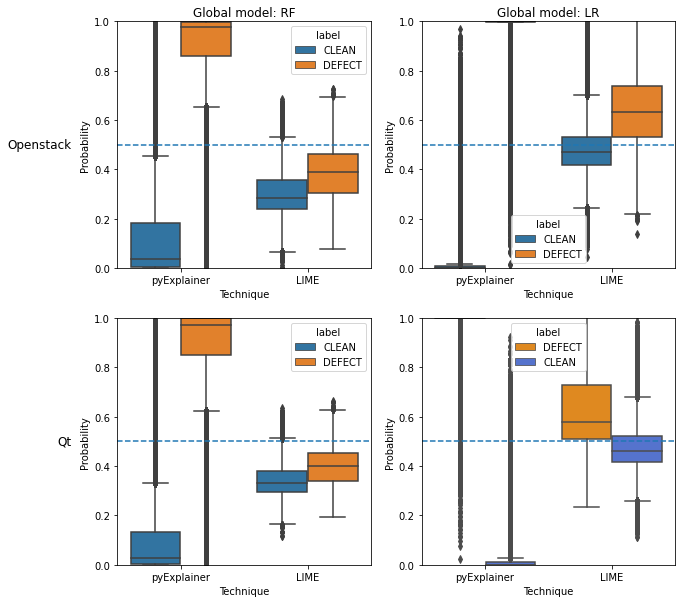

prob                      \
                                               count      mean       std   
global_model project   technique   label                                   
LR           openstack LIME        CLEAN    756538.0  0.479161  0.097755   
                                   DEFECT  1123462.0  0.642711  0.139488   
                       pyExplainer CLEAN    253037.0  0.052923  0.168400   
                                   DEFECT   563295.0  0.976227  0.066827   
             qt        LIME        CLEAN    514837.0  0.472187  0.096829   
                                   DEFECT   760163.0  0.613272  0.140216   
                       pyExplainer CLEAN    156714.0  0.066717  0.186804   
                                   DEFECT   402422.0  0.974019  0.077404   
RF           openstack LIME        CLEAN    826373.0  0.301598  0.085160   
                                   DEFECT   163627.0  0.389439  0.103161   
                       pyExplainer CLEAN    191104.0  0.132174  0.190765   
                                   DEFECT   242188.0  0.895710  0.163307   
             qt        LIME        CLEAN    341337.0  0.339087  0.062928   
                                   DEFECT    53663.0  0.399689  0.073872   
                       pyExplainer CLEAN     89560.0  0.108001  0.170155   
                                   DEFECT    84115.0  0.885009  0.174357   

                                                                       \
                                                    min           25%   
global_model project   technique   label                                
LR           openstack LIME        CLEAN   4.507063e-02  4.168422e-01   
                                   DEFECT  1.400477e-01  5.309150e-01   
                       pyExplainer CLEAN   6.901030e-67  1.414730e-08   
                                   DEFECT  1.288966e-02  9.986839e-01   
             qt        LIME        CLEAN   1.109229e-01  4.158501e-01   
                                   DEFECT  2.343638e-01  5.079015e-01   
                       pyExplainer CLEAN   3.949221e-73  1.514627e-08   
                                   DEFECT  2.191274e-02  9.993816e-01   
RF           openstack LIME        CLEAN   1.859033e-03  2.419097e-01   
                                   DEFECT  7.873959e-02  3.057614e-01   
                       pyExplainer CLEAN   2.622955e-26  3.838811e-03   
                                   DEFECT  7.134740e-04  8.608134e-01   
             qt        LIME        CLEAN   1.168993e-01  2.938756e-01   
                                   DEFECT  1.937341e-01  3.371553e-01   
                       pyExplainer CLEAN   4.147231e-10  3.388991e-03   
                                   DEFECT  4.410378e-03  8.478892e-01   

                                                                         
                                                50%       75%       max  
global_model project   technique   label                                 
LR           openstack LIME        CLEAN   0.471072  0.530925  1.080255  
                                   DEFECT  0.632518  0.739032  1.189965  
                       pyExplainer CLEAN   0.000044  0.007333  0.966620  
                                   DEFECT  0.999992  1.000000  1.000000  
             qt        LIME        CLEAN   0.460449  0.520455  1.009815  
                                   DEFECT  0.578885  0.727843  1.101923  
                       pyExplainer CLEAN   0.000045  0.010622  0.922699  
                                   DEFECT  0.999996  1.000000  1.000000  
RF           openstack LIME        CLEAN   0.282687  0.358454  0.685043  
                                   DEFECT  0.390274  0.462185  0.724992  
                       pyExplainer CLEAN   0.039361  0.183860  0.997376  
                                   DEFECT  0.977262  0.998434  1.000000  
             qt        LIME        CLEAN   0.329177  0.381216  0.635267  
                               

In [19]:
show_rq2_prob_distribution()

In [29]:
# def raname_files(proj_name):
#     global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name = 'RF')
#     all_eval_result = pd.DataFrame()
#     x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')

#     for i in range(0,len(x_test)):
#         X_explain = x_test.iloc[[i]]

#         row_index = str(X_explain.index[0])
        
# #         old_filename = pyExp_dir+proj_name+'_all_explainer_'+row_index+'.pkl'
#         new_filename = pyExp_dir+proj_name+'_RF_all_explainer_'+row_index+'.pkl'
#         exp_obj = pickle.load(open(new_filename,'rb'))
        
#         # new filename: pyExp_dir+proj_name+'_RF_all_explainer_'+row_index+'.pkl'
# #         print(exp_obj.keys())
        
# #         pickle_file = pickle.load(open(pyExp_dir+proj_name+'_LR_all_explainer_'+row_index+'.pkl','rb'))
# #         os.rename(old_filename, new_filename)
        
#         break

#     print('finished')

In [31]:
# raname_files('openstack')
# raname_files('qt')

In [174]:
# roc_auc_score

# f1_score

# balanced_accuracy_score

# precision_score

# recall_score

def classification_eval(prob, pred, label):
    auc = roc_auc_score(label,prob)
    f1 = f1_score(label,pred)
    bal_acc = balanced_accuracy_score(label,pred)
    prec = precision_score(label,pred)
    rec = recall_score(label,pred)
    
    return auc, bal_acc, prec, rec, f1

def rq2_2_eval(proj_name, global_model_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name)
    x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
#     ground_truth = np.ones(len(feature_df)).astype(bool)
    
    categorical_features_list = [6]
    
    class_label = ['clean', 'defect']
    
#     lime_explainer = LimeTabularExplainer(x_train.values, categorical_features=categorical_features_list, 
#                                       feature_names=indep, class_names=class_label,
#                                       random_state=0)

    
    py_exp_prob, py_exp_pred = [], []
    lime_prob, lime_pred = [], []
    
    local_pred_df = pd.DataFrame()
    
    for i in range(0,len(x_test)):
        X_explain = x_test.iloc[[i]]

        row_index = str(X_explain.index[0])

        exp_obj = pickle.load(open(pyExp_dir+proj_name+'_'+global_model_name+'_all_explainer_'+row_index+'.pkl','rb'))
#         print(exp_obj.keys())
        py_exp = exp_obj['pyExplainer']
        lime_exp = exp_obj['LIME']

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        
        selected_feature_indices = lime_exp['selected_feature_indeces']
        lime_input = np.ones((1,len(selected_feature_indices)))

        py_exp_local_prob = py_exp_local_model.predict_proba(X_explain.values)[:,1][0]
        py_exp_local_pred = py_exp_local_model.predict(X_explain.values)[0]

        lime_exp_local_prob = lime_exp_local_model.predict(lime_input)[0]
        lime_exp_local_pred = np.round(lime_exp_local_prob).astype(bool)

#         print(py_exp_local_prob, py_exp_local_pred, lime_exp_local_prob, lime_exp_local_pred)
#         print('predict finished')
        
        py_exp_prob.append(py_exp_local_prob)
        py_exp_pred.append(py_exp_local_pred)
        
        
        lime_prob.append(lime_exp_local_prob)
        lime_pred.append(lime_exp_local_pred)
#         print(py_exp_local_prob, py_exp_local_pred, lime_exp_local_prob, lime_exp_local_pred)
#         print(py_exp_pred, lime_pred)
        
#         if py_exp_pred == 1:
#             py_exp_pred_count = py_exp_pred_count +1
#         if lime_pred == 1:
#             lime_pred_count = lime_pred_count + 1

#         del py_exp, lime_exp, py_exp_local_model, lime_exp_local_model
#         print(py_exp_local_pred, lime_exp_local_pred)
#         print('finished {}/{} instances'.format(i, len(x_test)))
#         break
  
#         if i > 5:
#             break
            
    local_pred_df['ground_truth'] = list(y_test)
    local_pred_df['pyExplainer_prob'] = py_exp_prob
    local_pred_df['pyExplainer_pred'] = py_exp_pred
    local_pred_df['lime_prob'] = lime_prob
    local_pred_df['lime_pred'] = lime_pred
    
    local_pred_df.to_csv(dump_dataframe_dir+proj_name+'_'+global_model_name+'_local_prediction_of_actual_test_data.csv',index=False)
    
    print('pyExplainer')
    tn, fp, fn, tp = confusion_matrix(y_test, py_exp_pred).ravel()
    print(tn, fp, fn, tp)
    auc, bal_acc, prec, rec, f1 = classification_eval(py_exp_prob, py_exp_pred, y_test)
    print(auc, bal_acc, prec, rec, f1)
    
    print('LIME')
    tn, fp, fn, tp = confusion_matrix(y_test, lime_pred).ravel()
    print(tn, fp, fn, tp)
    auc, bal_acc, prec, rec, f1 = classification_eval(lime_prob, lime_pred, y_test)
    print(auc, bal_acc, prec, rec, f1)
    
    print('finished RQ2.2 of',proj_name)

In [175]:
start = time.time()
rq2_2_eval('openstack', 'RF')
end = time.time()
print('time spent {} secs'.format(end-start))

pyExplainer
2945 372 437 209
0.6964534889690132 0.6056899395272127 0.35972461273666095 0.3235294117647059 0.3406682966585167
LIME
2781 536 317 329
0.760267726721617 0.6738480629387404 0.38034682080924853 0.5092879256965944 0.4354731965585705
finished RQ2.2 of openstack
time spent 241.54043197631836 secs


In [176]:
start = time.time()
rq2_2_eval('qt', 'RF')
end = time.time()
print('time spent {} secs'.format(end-start))

pyExplainer
7385 416 363 113
0.6704893468732193 0.5920342306900969 0.21361058601134217 0.23739495798319327 0.22487562189054727
LIME
7541 260 421 55
0.7010281487290468 0.5411085790552601 0.1746031746031746 0.11554621848739496 0.1390644753476612
finished RQ2.2 of qt
time spent 483.0960168838501 secs


In [177]:
start = time.time()
rq2_2_eval('qt', 'RF')
end = time.time()
print('time spent {} secs'.format(end-start))

pyExplainer
7385 416 363 113
0.6704893468732193 0.5920342306900969 0.21361058601134217 0.23739495798319327 0.22487562189054727
LIME
7541 260 421 55
0.7010281487290468 0.5411085790552601 0.1746031746031746 0.11554621848739496 0.1390644753476612
finished RQ2.2 of qt
time spent 478.83206510543823 secs


In [178]:
# done later...
# start = time.time()
# rq2_2_eval('qt', 'LR')
# end = time.time()
# print('time spent {} secs'.format(end-start))

In [183]:
# tn, fp, fn, tp
# auc, bal_acc, prec, rec, f1
rf_result = pd.DataFrame()
rf_result = rf_result.append(pd.Series(['Openstack','pyExplainer',0.6964534889690132,0.6056899395272127, 0.35972461273666095, 0.3235294117647059, 0.3406682966585167]),ignore_index=True)
rf_result = rf_result.append(pd.Series(['Openstack','LIME',0.760267726721617,0.6738480629387404, 0.38034682080924853, 0.5092879256965944 ,0.4354731965585705]),ignore_index=True)
rf_result = rf_result.append(pd.Series(['Qt','pyExplainer',0.6704893468732193,0.5907915274813937, 0.21092278719397364, 0.23529411764705882, 0.2224428997020854]),ignore_index=True)
rf_result = rf_result.append(pd.Series(['Qt','LIME',0.7010281487290468,0.5409803903615029, 0.17350157728706625, 0.11554621848739496, 0.13871374527112232]),ignore_index=True)

rf_result.columns = ['project','method','AUC','Balance ACC','Precision','Recall','F1']
display(rf_result)

,project,method,AUC,Balance ACC,Precision,Recall,F1
0,Openstack,pyExplainer,0.696453,0.605690,0.359725,0.323529,0.340668
1,Openstack,LIME,0.760268,0.673848,0.380347,0.509288,0.435473
2,Qt,pyExplainer,0.670489,0.590792,0.210923,0.235294,0.222443
3,Qt,LIME,0.701028,0.540980,0.173502,0.115546,0.138714


In [28]:
x_test, y_test = prepare_data('openstack', mode = 'test')
openstack_local_pred_df = pd.read_csv(dump_dataframe_dir+'openstack_local_prediction_of_actual_test_data.csv')
display(openstack_local_pred_df)
pyexp_auc = roc_auc_score(y_test, openstack_local_pred_df['pyExplainer_prob'])
lime_auc = roc_auc_score(y_test, openstack_local_pred_df['lime_prob'])

print(pyexp_auc, lime_auc)

,ground_truth,pyExplainer_prob,pyExplainer_pred,lime_prob,lime_pred
0,False,0.006261,False,0.330719,False
1,False,0.003916,False,0.423250,False
2,False,0.004230,False,0.330505,False
3,False,0.886933,True,0.586833,True
4,False,0.030846,False,0.494419,False
...,...,...,...,...,...
3958,False,0.266964,False,0.033340,False
3959,False,0.000002,False,0.569094,True
3960,False,0.000042,False,0.271275,False
3961,False,0.003399,False,0.044495,False


0.7093740753842434 0.7598948469793005


In [118]:
rq2_2_eval('qt')

dict_keys(['pyExplainer', 'LIME'])
False False
finished 0/8277 instances
finished RQ555 of qt


## Just check number of explainers

In [55]:
import re, os
file_dir = './pyExplainer_obj'
all_files = os.listdir(file_dir)
# print(len(all_files))
op_pat = 'openstack_LR_all_explainer_.*'
qt_pat = 'qt_LR_all_explainer_.*'
op_p = re.compile(op_pat)
qt_p = re.compile(qt_pat)
op_list  = [ s for s in all_files if op_p.match(s) ]
qt_list  = [ s for s in all_files if qt_p.match(s) ]

# print(op_list)
print(len(op_list))
print(len(qt_list))

# print(op_list[100:105])
# print(qt_list[100:105])

1129
1092


# RQ3 evaluation

In [7]:
def eval_rule(rule, x_df):
    var_in_rule = list(set(re.findall('[a-zA-Z]+', rule)))
    
    rule = re.sub(r'\b=\b','==',rule)
    if 'or' in var_in_rule:
        var_in_rule.remove('or')
        
    rule = rule.replace('&','and')
    
    eval_result_list = []
    
#     print(rule)

    for i in range(0,len(x_df)):
        x = x_df.iloc[[i]]
        col = x.columns
        var_dict = {}

        for var in var_in_rule:
            var_dict[var] = float(x[var])

#         print(var_dict)
        
        # if the rule does not satisfy clean commit, the truth value of the inversed rule when applied to clean commit is true
        eval_result = eval(rule,var_dict)
        eval_result_list.append(eval_result)
        
#         print(eval_result)
#         break
        
    return eval_result_list

# def summarize_rule_eval_result(py_exp_rule_str, lime_rule_str, x_df, ground_truth):
# #     print('Rulefit')
#     py_exp_all_eval_result = eval_rule(py_exp_rule_str, x_df)
# #     print('LIME')
#     lime_all_eval_result = eval_rule(lime_rule_str, x_df)

# #     print(py_exp_rule_str)
# #     print(lime_rule_str)
    
# #     tmp_df = x_df.copy()
# #     tmp_df['ground_truth'] = ground_truth
# #     tmp_df_clean = tmp_df[tmp_df['ground_truth']==False]
    
# #     display(tmp_df_clean)
    
#     py_exp_result_df = pd.DataFrame()
#     py_exp_result_df['ground_truth'] = ground_truth
#     py_exp_result_df['rule_result'] = py_exp_all_eval_result
#     py_exp_result_df = py_exp_result_df[py_exp_result_df['rule_result']==True] # get commit that matches counter rule
    
# #     print('py_exp_result_df')
# #     display(py_exp_result_df[py_exp_result_df['ground_truth']==False])
# #     print(len(py_exp_result_df))
#     # find ratio of clean commit
#     py_exp_satisfy_rule_ratio = 100*(len(py_exp_result_df[py_exp_result_df['ground_truth']==False])/len(py_exp_result_df)) if len(py_exp_result_df) > 0 else 0
    
#     lime_result_df = pd.DataFrame()
#     lime_result_df['ground_truth'] = ground_truth
#     lime_result_df['rule_result'] = lime_all_eval_result
    
#     lime_result_df = lime_result_df[lime_result_df['rule_result']==True] # get commit that matches counter rule
    
# #     print(len(lime_result_df))
    
#     # find ratio of clean commit
# #     print('lime_result_df')
# #     display(lime_result_df[lime_result_df['ground_truth']==False])
#     lime_satisfy_rule_ratio = 100*(len(lime_result_df[lime_result_df['ground_truth']==False])/len(lime_result_df))  if len(lime_result_df) > 0 else 0
    
# #     print(len(py_exp_result_df[py_exp_result_df['ground_truth']==False]))
# #     print(len(lime_result_df[lime_result_df['ground_truth']==False]))
    
#     return py_exp_satisfy_rule_ratio, lime_satisfy_rule_ratio

def summarize_rule_eval_result(rule_str, x_df):
#     print('Rulefit')
    all_eval_result = eval_rule(rule_str, x_df)
    all_eval_result = np.array(all_eval_result).astype(bool)
    
#     result_df = pd.DataFrame()
#     result_df['ground_truth'] = ground_truth
#     result_df['rule_result'] = all_eval_result
#     result_df = result_df[result_df['rule_result']==True] # get commit that matches counter rule
    
#     print('py_exp_result_df')
#     display(py_exp_result_df[py_exp_result_df['ground_truth']==False])
#     print(len(py_exp_result_df))
    # find ratio of clean commit
#     satisfy_rule_ratio = 100*(len(result_df[result_df['ground_truth']==False])/len(result_df)) if len(result_df) > 0 else 0

    return all_eval_result

'''
    input:
        local_model: local model of PyExplainer
        X_explain: an instance to be explained
        
    return:
        g2_guide, g4_guide (string)
        more info of g2/g4 guidance refers to SQAPlanner paper
'''

def get_g2_g4_guidance(local_model, X_explain):
    rules = local_model.get_rules()
    rules = rules[(rules['type']=='rule') & (rules['coef'] < 0) & (rules['importance'] > 0)]
    rules_list = list(rules['rule'])
    
    rule_eval_result = []

    for r in rules_list:
        py_exp_pred = eval_rule(r, X_explain)[0]
        rule_eval_result.append(py_exp_pred)
        
    rules['is_satisfy_instance'] = rule_eval_result
    
    g2_guide_df = rules[rules['is_satisfy_instance']==True]
    g4_guide_df = rules[rules['is_satisfy_instance']==False]

    g2_guide_df = g2_guide_df.sort_values(by='importance', ascending=False)
    g4_guide_df = g4_guide_df.sort_values(by='importance', ascending=False)
    
    g2_guide = g2_guide_df.iloc[0]['rule']
    g4_guide = g4_guide_df.iloc[0]['rule']
    
    return g2_guide, g4_guide

In [8]:
def test_rule(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_namez)
    x_test, y_test = prepare_data(proj_name, mode = 'test')
    
    rq3_eval_result = pd.DataFrame() # for train data

    py_exp_guide = []
    lime_guide = []
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        
        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
#         print(py_exp_the_best_defective_rule_str)
        
        total_cond_in_py_exp = len(py_exp_the_best_defective_rule_str.split('&'))
        
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]

        py_exp_pred = eval_rule(py_exp_the_best_defective_rule_str, X_explain)[0]
        lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

#         print(py_exp_pred, lime_pred)
        if py_exp_pred:
            py_exp_the_best_defective_rule_str = flip_rule(py_exp_the_best_defective_rule_str)
            py_exp_guide.append(py_exp_the_best_defective_rule_str)

        if lime_pred:
            lime_the_best_defective_rule_str = flip_rule(lime_the_best_defective_rule_str)
            lime_guide.append(lime_the_best_defective_rule_str)
        
    print(set(py_exp_guide))
    print('total guidance:',len(set(py_exp_guide)))
    print('-'*100)
    print(set(lime_guide))
    print('total guidance:',len(set(lime_guide)))

In [9]:
# test_rule('openstack')

In [10]:
# test_rule('qt')

## Just for testing

In [63]:
global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing('openstack', 'RF')
# display(feature_df.head())

exp_obj = pickle.load(open(pyExp_dir+'openstack'+'_'+'RF'+'_all_explainer_'+'7b64653931628328bd5d70b0cdea8952e6c709f8'+'.pkl','rb'))
py_exp = exp_obj['pyExplainer']
lime_exp = exp_obj['LIME']
print(py_exp.keys())
print(lime_exp.keys())

dict_keys(['synthetic_data', 'synthetic_predictions', 'X_explain', 'y_explain', 'indep', 'dep', 'top_k_positive_rules', 'top_k_negative_rules', 'commit_id', 'local_model'])
dict_keys(['rule', 'synthetic_instance_for_global_model', 'synthetic_instance_for_lobal_model', 'local_model', 'selected_feature_indeces', 'commit_id'])


In [60]:
# display(py_exp['synthetic_data'])
synthetic_label = py_exp['synthetic_predictions']
print(synthetic_label[:30])
synthetic_label_inverse = [False if val else True for val in synthetic_label]
print(synthetic_label_inverse[:30])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


In [54]:
lime_synthetic_inst = lime_exp['synthetic_instance_for_global_model']
lime_synthetic_inst_df = pd.DataFrame(lime_synthetic_inst, columns = indep)
display(lime_synthetic_inst_df)
display(lime_exp[])

,la,nd,ns,ent,nrev,rtime,self,ndev,age,app,rrexp,asawr,rsawr
0,455.000000,2.000000,1.0,0.837242,6.000000,38.506863,0.0,5.000000,12.452422,4.000000,669.000000,0.004604,0.592081
1,145.227329,0.000000,0.0,0.000000,6.154696,-97.303030,0.0,49.448128,0.143541,1.513948,1090.156555,0.002797,0.534785
2,22.579517,2.000000,0.0,0.795894,4.160033,1.081481,0.0,9.208346,1.883333,4.173444,917.355182,0.608859,0.519152
3,0.031754,2.000000,0.0,0.000000,16.096111,2.825595,0.0,6.152092,1.148246,0.900464,186.356035,0.091937,0.647910
4,41.807820,3.000000,0.0,0.758795,2.000000,33.713614,0.0,46.928210,0.246755,1.859324,192.306665,0.134505,0.336642
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,9.909193,2.000000,0.0,0.000000,11.781315,-200.874469,0.0,88.079354,6.884962,3.000000,481.881605,0.002427,0.334578
4996,319.480726,5.097735,0.0,0.921161,14.953256,1.197192,0.0,65.709892,1.146383,3.000000,56.519357,0.467129,0.484491
4997,16.515573,0.000000,0.0,0.812743,3.320608,4.627267,0.0,135.396254,1.309410,1.912545,204.924668,0.032909,0.342357
4998,10.742851,0.000000,0.0,0.000000,0.904586,4.423934,0.0,84.232510,4.114324,5.153511,2333.164924,0.020840,0.438875


In [64]:
print(py_exp.keys())
local_model = py_exp['local_model']
rules = local_model.get_rules()
rules = rules[(rules['type']=='rule') & (rules['coef'] < 0) & (rules['importance'] > 0)]
display(rules.head())
# print(len(rules))

# display(row_index)
X_explain = feature_df.iloc[[0]]
display(X_explain)

rules_list = list(rules['rule'])

dict_keys(['synthetic_data', 'synthetic_predictions', 'X_explain', 'y_explain', 'indep', 'dep', 'top_k_positive_rules', 'top_k_negative_rules', 'commit_id', 'local_model'])


,rule,type,coef,support,importance
13,age <= 0.10500000044703484,rule,-0.053777,0.148825,0.019140
14,la <= 97.53499984741211 & app <= 2.03499996662...,rule,-0.028525,0.096606,0.008427
15,la > 0.3400000333786011 & app > 3.064999938011...,rule,-0.056829,0.326371,0.026646
16,ent > 0.9549999833106995 & app <= 4.9600000381...,rule,-0.041321,0.185379,0.016058
18,nrev > 1.0149999856948853 & la <= 8.3000001907...,rule,-0.064843,0.127937,0.021659


,la,nd,ns,ent,nrev,rtime,self,ndev,age,app,rrexp,asawr,rsawr
commit_id,,,,,,,,,,,,,
1e6973aee7137653c62dcef970b1e2527b50517d,258,2,1,0.826278,2.0,18.04956,0,1.0,5.242755,4.0,465.0,0.004262,0.082046


In [177]:
# print(rules_list[:3])

In [66]:
rule_eval_result = []

for r in rules_list:
    py_exp_pred = eval_rule(r, X_explain)[0]
    rule_eval_result.append(py_exp_pred)
#     print(py_exp_pred)

#     if py_exp_pred:
#         print(py_exp_pred)
#         print(r)
#         break

In [67]:
rules['is_satisfy_instance'] = rule_eval_result

In [68]:
# display(rules)

In [69]:
g2_rule_df = rules[rules['is_satisfy_instance']==True]
g4_rule_df = rules[rules['is_satisfy_instance']==False]

g2_rule_df = g2_rule_df.sort_values(by='importance', ascending=False)
g4_rule_df = g4_rule_df.sort_values(by='importance', ascending=False)

display(g2_rule_df)
display(g4_rule_df)

,rule,type,coef,support,importance,is_satisfy_instance
1235,ent > 0.32500000298023224 & nrev <= 2.10000002...,rule,-0.238833,0.182768,0.092303,True
64,nrev > 1.0149999856948853 & nrev <= 2.03999996...,rule,-0.364617,0.067885,0.091719,True
304,nrev > 1.850000023841858 & app > 2.99000000953...,rule,-0.183931,0.548303,0.091535,True
1713,nrev > 1.0049999952316284 & app > 2.9900000095...,rule,-0.171510,0.524804,0.085649,True
466,age > 1.3250000476837158 & la > 17.02499961853...,rule,-0.161026,0.456919,0.080214,True
...,...,...,...,...,...,...
112,app > 3.859999895095825 & app > 3.009999990463...,rule,-0.001290,0.190601,0.000506,True
77,nrev <= 7.634999990463257 & rrexp > 314.449996...,rule,-0.000671,0.584856,0.000331,True
1109,app > 2.0049999952316284 & app > 2.99000000953...,rule,-0.000664,0.436031,0.000329,True
234,ent <= 0.9350000023841858 & ent <= 0.894999980...,rule,-0.000501,0.180157,0.000193,True


,rule,type,coef,support,importance,is_satisfy_instance
762,rtime > 0.014999999664723873 & rtime <= 9.9099...,rule,-0.325320,0.425587,0.160849,False
1573,nrev > 3.990000009536743 & nrev <= 7.105000019...,rule,-0.225563,0.344648,0.107200,False
1780,age <= 26.53499984741211 & nd > 1.560000002384...,rule,-0.215652,0.595300,0.105849,False
539,nrev > 2.8549998998641968 & nrev <= 3.01999998...,rule,-0.292641,0.112272,0.092387,False
1074,rtime <= 6.944999933242798 & app > 2.920000076...,rule,-0.218485,0.211488,0.089221,False
...,...,...,...,...,...,...
820,app <= 3.9100000858306885,rule,-0.000367,0.819843,0.000141,False
1588,la > 76.17499923706055 & nrev <= 1.01999998092...,rule,-0.000636,0.023499,0.000096,False
20,asawr > 0.024999999441206455 & rtime > 6.19000...,rule,-0.000101,0.234987,0.000043,False
1411,ndev > 53.454999923706055 & la > 9.42500019073...,rule,-0.000122,0.015666,0.000015,False


In [70]:
g2_rule = g2_rule_df.iloc[0]['rule']
g4_rule = g4_rule_df.iloc[0]['rule']

print(g2_rule)
print(g4_rule)

ent > 0.32500000298023224 & nrev <= 2.100000023841858 & nrev <= 2.9800000190734863
rtime > 0.014999999664723873 & rtime <= 9.90999984741211


In [17]:
guidance = 'a > 10 & b < 5 & c >= 23'

print(flip_guidance)

a <= 10 & b >= 5 & c < 23


In [77]:
def eval_PyExplainer_guidance(proj_name, global_model, method_name, row_index, guidance, x_test, y_test_flip , flip=False):
#     guidance_list = guidance.split('&')
    
    if flip:
        flip_condition_list = []
        guidance_list = guidance.split('&')
        
        for condition in guidance_list:
            condition = flip_rule(condition)
            flip_condition_list.append(condition.strip())
            
        guidance = ' & '.join(flip_condition_list)
        
    guide_eval_result = pd.DataFrame()
            
    py_exp_guidance_eval = summarize_rule_eval_result(guidance, x_test)

    guide_prec = precision_score(y_test_flip, py_exp_guidance_eval)
    guide_rec = recall_score(y_test_flip, py_exp_guidance_eval)

    py_exp_serie_test = pd.Series(data=[proj_name, row_index, method_name, global_model,guidance, guide_prec, guide_rec])
    guide_eval_result = guide_eval_result.append(py_exp_serie_test,ignore_index=True)
        
    return guide_eval_result

In [83]:
## use inverse rule to predict train/test clean instance
def rq3_eval(proj_name, global_model_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name)
    x_test, y_test = prepare_data(proj_name, mode = 'test')
    
    y_test_flip = [False if val else True for val in y_test]
    
    rq3_explanation_result = pd.DataFrame()
    
    pyexp_guidance_result_list = []
    lime_guidance_result_df = pd.DataFrame()
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        exp_obj = pickle.load(open(pyExp_dir+proj_name+'_'+global_model_name+'_all_explainer_'+row_index+'.pkl','rb'))
        py_exp = exp_obj['pyExplainer']
        lime_exp = exp_obj['LIME']

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        
        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]

        py_exp_pred = eval_rule(py_exp_the_best_defective_rule_str, X_explain)[0]
        lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

        if py_exp_pred:
            
            synthetic_data = py_exp['synthetic_data']
            synthetic_label = py_exp['synthetic_predictions']
            synthetic_label_flip = [False if val else True for val in synthetic_label]

            condition_list = py_exp_the_best_defective_rule_str.split('&')

            # for explanation
            for condition in condition_list:
                condition = condition.strip()
                
                py_exp_rule_eval = summarize_rule_eval_result(condition, synthetic_data)

                rule_prec = precision_score(synthetic_label, py_exp_rule_eval)
                rule_rec = recall_score(synthetic_label, py_exp_rule_eval)

                py_exp_serie_test = pd.Series(data=[proj_name, row_index, 'pyExplainer',global_model_name, condition, rule_prec, rule_rec])
                rq3_explanation_result = rq3_explanation_result.append(py_exp_serie_test,ignore_index=True)

            # for guidance
            g2_guide, g4_guide = get_g2_g4_guidance(py_exp_local_model, X_explain)
            
            flip_guide_eval_result = eval_PyExplainer_guidance(proj_name, global_model_name,'PyExpFlip', row_index,
                                                               py_exp_the_best_defective_rule_str, synthetic_data, synthetic_label_flip, flip=True)
            g2_guide_eval_result = eval_PyExplainer_guidance(proj_name, global_model_name,'PyExpG2', row_index,
                                                               g2_guide, synthetic_data, synthetic_label_flip, flip=False)
            g4_guide_eval_result = eval_PyExplainer_guidance(proj_name, global_model_name,'PyExpG4', row_index,
                                                               g4_guide, synthetic_data, synthetic_label_flip, flip=False)
            
            pyexp_guidance_result_list.append(flip_guide_eval_result)
            pyexp_guidance_result_list.append(g2_guide_eval_result)
            pyexp_guidance_result_list.append(g4_guide_eval_result)
            
#             break
        
        if lime_pred:
            lime_synthetic_inst = lime_exp['synthetic_instance_for_global_model']
            lime_synthetic_inst_df = pd.DataFrame(lime_synthetic_inst, columns = indep)

            lime_synthetic_label = global_model.predict(lime_synthetic_inst_df)
#             print(lime_synthetic_label)
            lime_synthetic_label_flip = [False if val else True for val in lime_synthetic_label]
#             print(lime_synthetic_label_flip)

#             break
            lime_rule_eval = summarize_rule_eval_result(lime_the_best_defective_rule_str, lime_synthetic_inst_df)
            
            rule_prec = precision_score(lime_synthetic_label, lime_rule_eval)
            rule_rec = recall_score(lime_synthetic_label, lime_rule_eval)
            
            lime_serie_test = pd.Series(data=[proj_name, row_index, 'LIME',global_model_name, lime_the_best_defective_rule_str, rule_prec, rule_rec])
            rq3_explanation_result = rq3_explanation_result.append(lime_serie_test,ignore_index=True)
            
            lime_guidance = flip_rule(lime_the_best_defective_rule_str)
            lime_guidance_eval = summarize_rule_eval_result(lime_guidance, lime_synthetic_inst_df)
#             tn, fp, fn, tp = confusion_matrix(y_test, lime_rule_eval, labels=[1,0]).ravel()
#             tp_rate = tp/(tp+fn)
#             tn_rate = tn/(tn+fp)
            
            guide_prec = precision_score(lime_synthetic_label_flip, lime_guidance_eval)
            guide_rec = recall_score(lime_synthetic_label_flip, lime_guidance_eval)
            
            lime_serie_test = pd.Series(data=[proj_name, row_index, 'LIME', global_model_name, lime_guidance, guide_prec, guide_rec])
            lime_guidance_result_df = lime_guidance_result_df.append(lime_serie_test, ignore_index=True)
            
        print('finished {} from {} commits'.format(str(i+1),len(feature_df)))
        
        
    pyexp_guidance_result_df = pd.concat(pyexp_guidance_result_list)
    
    rq3_guidance_result = pd.concat([pyexp_guidance_result_df, lime_guidance_result_df])
    
    
    
    rq3_explanation_result.columns = ['project','commit_id','method','global_model','explanation','precision','recall']
    rq3_guidance_result.columns = ['project','commit_id','method', 'global_model','guidance','precision','recall']

    rq3_explanation_result.to_csv(result_dir+'RQ3_'+proj_name+'_'+global_model_name+'_explanation_eval_original_rulefit_condition.csv',index=False)
    rq3_guidance_result.to_csv(result_dir+'RQ3_'+proj_name+'_'+global_model_name+'_guidance_eval_original_rulefit_condition.csv',index=False)

    print('finished RQ3 of',proj_name)
    

In [84]:
rq3_eval('openstack','RF')

finished 1 from 198 commits
finished 2 from 198 commits
finished 3 from 198 commits
finished 4 from 198 commits
finished 5 from 198 commits
finished 6 from 198 commits
finished 7 from 198 commits
finished 8 from 198 commits
finished 9 from 198 commits
finished RQ3 of openstack


NameError: name 'rq3_eval_result' is not defined

In [39]:
start = time.time()
print('openstack')
rq3_eval('openstack','RF')
end = time.time()
print('finished in',str(end-start), 'secs')

start = time.time()
print('qt')
rq3_eval('qt','RF')
end = time.time()
print('finished in',str(end-start), 'secs')

openstack
finished 1 from 198 commits
finished 2 from 198 commits
finished 3 from 198 commits
finished 4 from 198 commits
finished 5 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 6 from 198 commits


KeyboardInterrupt: 

In [ ]:
start = time.time()
print('openstack')
rq3_eval('openstack','LR')
end = time.time()
print('finished in',str(end-start), 'secs')

start = time.time()
print('qt')
rq3_eval('qt','LR')
end = time.time()
print('finished in',str(end-start), 'secs')

In [142]:
openstack_rf = pd.read_csv('./eval_result/RQ3_openstack_RF_guidance_eval_split_rulefit_condition.csv')
qt_rf = pd.read_csv('./eval_result/RQ3_qt_RF_guidance_eval_split_rulefit_condition.csv')
result_rf = pd.concat([openstack_rf, qt_rf])
result_rf['global_model'] = 'RF'

openstack_lr = pd.read_csv('./eval_result/RQ3_openstack_LR_guidance_eval_split_rulefit_condition.csv')
qt_lr = pd.read_csv('./eval_result/RQ3_qt_LR_split_guidance_eval_split_rulefit_condition.csv')
result_lr = pd.concat([openstack_lr, qt_lr])
result_lr['global_model'] = 'LR'

all_result = pd.concat([result_rf, result_lr])

all_result.to_csv('./eval_result/RQ3_guidance_eval_split_rulefit_condition.csv', index=False)

In [61]:
openstack_rf = pd.read_csv('./eval_result/RQ3_openstack_RF_guidance_eval_split_rulefit_condition.csv')
qt_rf = pd.read_csv('./eval_result/RQ3_qt_RF_guidance_eval_split_rulefit_condition.csv')
result_rf = pd.concat([openstack_rf, qt_rf])
result_rf['global_model'] = 'RF'

result_rf.to_csv('./eval_result/RQ3_RF_guidance_eval_split_rulefit_condition.csv',index=False)
# openstack_lr = pd.read_csv('./eval_result/RQ3_openstack_LR_guidance_eval_split_rulefit_condition.csv')
# qt_lr = pd.read_csv('./eval_result/RQ3_qt_LR_split_guidance_eval_split_rulefit_condition.csv')
# result_lr = pd.concat([openstack_lr, qt_lr])
# result_lr['global_model'] = 'LR'

# all_result = pd.concat([result_rf, result_lr])

# all_result.to_csv('./eval_result/RQ3_guidance_eval_split_rulefit_condition.csv', index=False)

In [62]:
openstack_rf = pd.read_csv('./eval_result/RQ3_openstack_RF_explanation_eval_split_rulefit_condition.csv')
qt_rf = pd.read_csv('./eval_result/RQ3_qt_RF_explanation_eval_split_rulefit_condition.csv')
result_rf = pd.concat([openstack_rf, qt_rf])
result_rf['global_model'] = 'RF'

result_rf.to_csv('./eval_result/RQ3_RF_explanation_eval_split_rulefit_condition.csv',index=False)
# openstack_lr = pd.read_csv('./eval_result/RQ3_openstack_LR_explanation_eval_split_rulefit_condition.csv')
# qt_lr = pd.read_csv('./eval_result/RQ3_qt_LR_split_explanation_eval_split_rulefit_condition.csv')
# result_lr = pd.concat([openstack_lr, qt_lr])
# result_lr['global_model'] = 'LR'

# all_result = pd.concat([result_rf, result_lr])

# all_result.to_csv('./eval_result/RQ3_explanation_eval_split_rulefit_condition.csv', index=False)

In [34]:
def show_rq3_explanation_eval_result():

    openstack_rf = pd.read_csv('./eval_result/RQ3_openstack_RF_new.csv')
    qt_rf = pd.read_csv('./eval_result/RQ3_qt_RF_new.csv')
    result_rf = pd.concat([openstack_rf, qt_rf])
    result_rf['global_model'] = 'RF'
    
    openstack_lr = pd.read_csv('./eval_result/RQ3_openstack_LR_new.csv')
    qt_lr = pd.read_csv('./eval_result/RQ3_qt_LR_new.csv')
    result_lr = pd.concat([openstack_lr, qt_lr])
    result_lr['global_model'] = 'LR'
    
    all_result = pd.concat([result_rf, result_lr])

#     display(all_result.head(10))
    
    my_pal = ['darkorange','blue']

    fig, axs = plt.subplots(2,2, figsize=(8,8))

    axs[0,0].set_title('RF')
    axs[0,1].set_title('LR')

    # plt.ylim(0,100)
    sns.boxplot(data=result_rf, x='project', y='explantion_precision', hue='method', ax=axs[0,0], palette=['darkorange','royalblue'])
    sns.boxplot(data=result_rf, x='project', y='explantion_recall', hue='method', ax=axs[1,0], palette=['darkorange','royalblue'])
    sns.boxplot(data=result_lr, x='project', y='explantion_precision', hue='method', ax=axs[0,1], palette=['royalblue','darkorange'])
    sns.boxplot(data=result_lr, x='project', y='explantion_recall', hue='method', ax=axs[1,1], palette=['royalblue','darkorange'])

    plt.show()
    
    display(all_result[['global_model', 'project','method', 'explantion_precision','explantion_recall']]
            .groupby(['global_model','project','method']).describe())
    
#     result_rf.to_csv('./eval_result/RQ3_RF.csv',index=False)
#     result_lr.to_csv('./eval_result/RQ3_LR.csv',index=False)
#     all_result.to_csv('./eval_result/RQ3.csv',index=False)
    
#     fig.savefig('./eval_result/figures/RQ3.png')
    

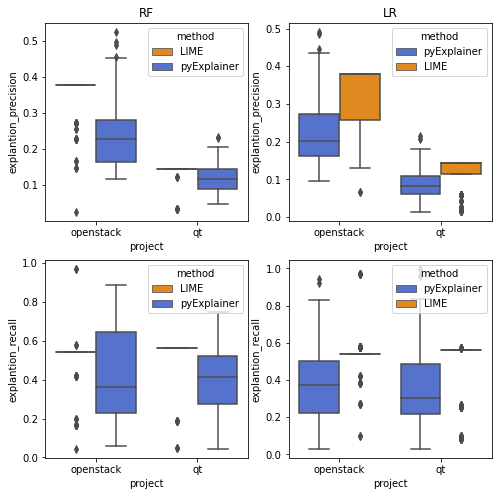

explantion_precision                      \
                                                  count      mean       std   
global_model project   method                                                 
LR           openstack LIME                       376.0  0.335419  0.075056   
                       pyExplainer                203.0  0.223915  0.081137   
             qt        LIME                       254.0  0.120941  0.042186   
                       pyExplainer                148.0  0.089164  0.037237   
RF           openstack LIME                       198.0  0.357511  0.057134   
                       pyExplainer                113.0  0.250254  0.097709   
             qt        LIME                        48.0  0.123950  0.041644   
                       pyExplainer                 43.0  0.121098  0.046245   

                                                                            \
                                         min       25%       50%       75%   
global_model project   method                                                
LR           openstack LIME         0.066259  0.256868  0.378936  0.378936   
                       pyExplainer  0.095949  0.161777  0.201790  0.273904   
             qt        LIME         0.015282  0.112635  0.143854  0.143854   
                       pyExplainer  0.014042  0.059482  0.082731  0.108330   
RF           openstack LIME         0.026630  0.378936  0.378936  0.378936   
                       pyExplainer  0.118156  0.165725  0.226885  0.281899   
             qt        LIME         0.032544  0.143854  0.143854  0.143854   
                       pyExplainer  0.047084  0.088905  0.118074  0.143709   

                                             explantion_recall            \
                                         max             count      mean   
global_model project   method                                              
LR           openstack LIME         0.378936             376.0  0.544768   
                       pyExplainer  0.491039             203.0  0.376085   
             qt        LIME         0.143854             254.0  0.485799   
                       pyExplainer  0.214912             148.0  0.351578   
RF           openstack LIME         0.378936             198.0  0.513400   
                       pyExplainer  0.525641             113.0  0.417340   
             qt        LIME         0.143854              48.0  0.467700   
                       pyExplainer  0.233333              43.0  0.406732   

                                                                            \
                                         std       min       25%       50%   
global_model project   method                                                
LR           openstack LIME         0.085677  0.100619  0.540248  0.540248   
                       pyExplainer  0.182666  0.029412  0.222910  0.369969   
             qt        LIME         0.154259  0.081933  0.563025  0.563025   
                       pyExplainer  0.190425  0.029412  0.215861  0.303571   
RF           openstack LIME         0.106922  0.044892  0.540248  0.540248   
                       pyExplainer  0.219388  0.058824  0.230650  0.363777   
             qt        LIME         0.179187  0.046218  0.563025  0.563025   
                       pyExplainer  0.184255  0.044118  0.277311  0.413866   

                                                        
                                         75%       max  
global_model project   method                           
LR           openstack LIME         0.540248  0.969040  
                       pyExplainer  0.499226  0.944272  
             qt        LIME         0.563025  0.569328  
                       pyExplainer  0.483718  0.995798  
RF           openstack LIME         0.540248  0.969040  
                       pyExplainer  0.645511  0.888545  
             qt        LIME         0.563025  0.563025  
                       pyExplainer  0.52

In [45]:
show_rq3_explanation_eval_result()

In [115]:
def show_rq3_guidance_eval_result():

    openstack_rf = pd.read_csv('./eval_result/RQ3_openstack_RF_new.csv')
    qt_rf = pd.read_csv('./eval_result/RQ3_qt_RF_new.csv')
    result_rf = pd.concat([openstack_rf, qt_rf])
    result_rf['global_model'] = 'RF'
    
    openstack_lr = pd.read_csv('./eval_result/RQ3_openstack_LR_new.csv')
    qt_lr = pd.read_csv('./eval_result/RQ3_qt_LR_new.csv')
    result_lr = pd.concat([openstack_lr, qt_lr])
    result_lr['global_model'] = 'LR'
    
    all_result = pd.concat([result_rf, result_lr])

#     display(all_result.head(10))
    
    my_pal = ['darkorange','blue']

    fig, axs = plt.subplots(2,2, figsize=(8,8))

    axs[0,0].set_title('RF')
    axs[0,1].set_title('LR')

    # plt.ylim(0,100)
    sns.boxplot(data=result_rf, x='project', y='guidance_precision', hue='method', ax=axs[0,0], palette=['darkorange','royalblue'])
    sns.boxplot(data=result_rf, x='project', y='guidance_recall', hue='method', ax=axs[1,0], palette=['darkorange','royalblue'])
    sns.boxplot(data=result_lr, x='project', y='guidance_precision', hue='method', ax=axs[0,1], palette=['royalblue','darkorange'])
    sns.boxplot(data=result_lr, x='project', y='guidance_recall', hue='method', ax=axs[1,1], palette=['royalblue','darkorange'])

    plt.show()
    
    display(all_result[['global_model', 'project','method', 'guidance_precision', 'guidance_recall']]
            .groupby(['global_model','project','method']).describe())
    
#     result_rf.to_csv('./eval_result/RQ3_RF.csv',index=False)
#     result_lr.to_csv('./eval_result/RQ3_LR.csv',index=False)
#     all_result.to_csv('./eval_result/RQ3.csv',index=False)
    
#     fig.savefig('./eval_result/figures/RQ3.png')
    

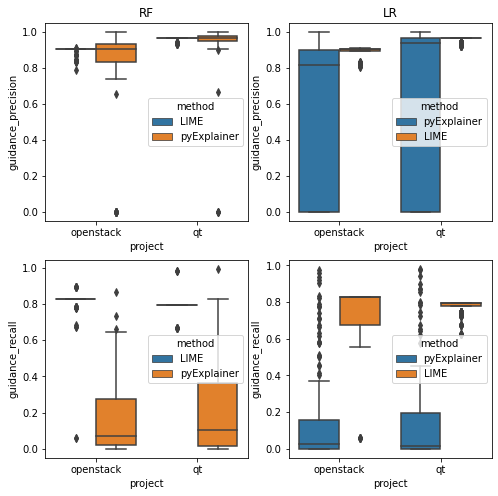

guidance_precision                      \
                                                count      mean       std   
global_model project   method                                               
LR           openstack LIME                     376.0  0.895572  0.019231   
                       pyExplainer              203.0  0.524223  0.432082   
             qt        LIME                     254.0  0.960790  0.013299   
                       pyExplainer              148.0  0.543352  0.476488   
RF           openstack LIME                     198.0  0.896500  0.017441   
                       pyExplainer              113.0  0.780344  0.312199   
             qt        LIME                      48.0  0.959895  0.014524   
                       pyExplainer               43.0  0.870868  0.286708   

                                                                            \
                                         min       25%       50%       75%   
global_model project   method                                                
LR           openstack LIME         0.805164  0.891504  0.902367  0.902367   
                       pyExplainer  0.000000  0.000000  0.816185  0.899352   
             qt        LIME         0.923668  0.965083  0.967571  0.967571   
                       pyExplainer  0.000000  0.000000  0.938391  0.966636   
RF           openstack LIME         0.785317  0.902367  0.902367  0.902367   
                       pyExplainer  0.000000  0.833847  0.904903  0.934010   
             qt        LIME         0.930379  0.967571  0.967571  0.967571   
                       pyExplainer  0.000000  0.950084  0.968157  0.979892   

                                             guidance_recall            \
                                         max           count      mean   
global_model project   method                                            
LR           openstack LIME         0.909910           376.0  0.766750   
                       pyExplainer  1.000000           203.0  0.141532   
             qt        LIME         0.967571           254.0  0.776564   
                       pyExplainer  1.000000           148.0  0.153491   
RF           openstack LIME         0.909910           198.0  0.817171   
                       pyExplainer  1.000000           113.0  0.160887   
             qt        LIME         0.967571            48.0  0.785239   
                       pyExplainer  1.000000            43.0  0.228498   

                                                                            \
                                         std       min       25%       50%   
global_model project   method                                                
LR           openstack LIME         0.129952  0.060898  0.673802  0.827555   
                       pyExplainer  0.238541  0.000000  0.000000  0.025023   
             qt        LIME         0.039294  0.628894  0.780028  0.795539   
                       pyExplainer  0.255501  0.000000  0.000000  0.016408   
RF           openstack LIME         0.080812  0.060898  0.827555  0.827555   
                       pyExplainer  0.187810  0.000000  0.020199  0.072656   
             qt        LIME         0.070521  0.664658  0.795539  0.795539   
                       pyExplainer  0.275514  0.000000  0.014614  0.101910   

                                                        
                                         75%       max  
global_model project   method                           
LR           openstack LIME         0.827555  0.827555  
                       pyExplainer  0.158577  0.976485  
             qt        LIME         0.795539  0.795539  
                       pyExplainer  0.197763  0.980259  
RF           openstack LIME         0.827555  0.889961  
                       pyExplainer  0.276153  0.866747  
             qt        LIME         0.795539  0.979746  
                       pyExplainer  0.361877  0.991155

In [116]:
show_rq3_guidance_eval_result()

In [56]:
def show_rq3_explanation_fp_eval_result():

    openstack_rf = pd.read_csv('./eval_result/RQ3_openstack_RF_new.csv')
    qt_rf = pd.read_csv('./eval_result/RQ3_qt_RF_new.csv')
    result_rf = pd.concat([openstack_rf, qt_rf])
    result_rf['global_model'] = 'RF'
    
    openstack_lr = pd.read_csv('./eval_result/RQ3_openstack_LR_new.csv')
    qt_lr = pd.read_csv('./eval_result/RQ3_qt_LR_new.csv')
    result_lr = pd.concat([openstack_lr, qt_lr])
    result_lr['global_model'] = 'LR'
    
    all_result = pd.concat([result_rf, result_lr])

#     display(all_result.head(10))
    
    my_pal = ['darkorange','blue']

    fig, axs = plt.subplots(1,2, figsize=(8,8))

    axs[0].set_title('RF')
    axs[1].set_title('LR')

    # plt.ylim(0,100)
    sns.boxplot(data=result_rf, x='project', y='explanation_false_positive', hue='method', ax=axs[0])
#     sns.boxplot(data=result_rf, x='project', y='guidance_recall', hue='method', ax=axs[1,0], palette=['darkorange','royalblue'])
    sns.boxplot(data=result_lr, x='project', y='explanation_false_positive', hue='method', ax=axs[1])
#     sns.boxplot(data=result_lr, x='project', y='guidance_recall', hue='method', ax=axs[1,1], palette=['royalblue','darkorange'])

    plt.show()
    
    display(all_result[['global_model', 'project','method', 'explanation_false_positive']]
            .groupby(['global_model','project','method']).describe())
    
#     result_rf.to_csv('./eval_result/RQ3_RF.csv',index=False)
#     result_lr.to_csv('./eval_result/RQ3_LR.csv',index=False)
#     all_result.to_csv('./eval_result/RQ3.csv',index=False)
    
#     fig.savefig('./eval_result/figures/RQ3.png')
    

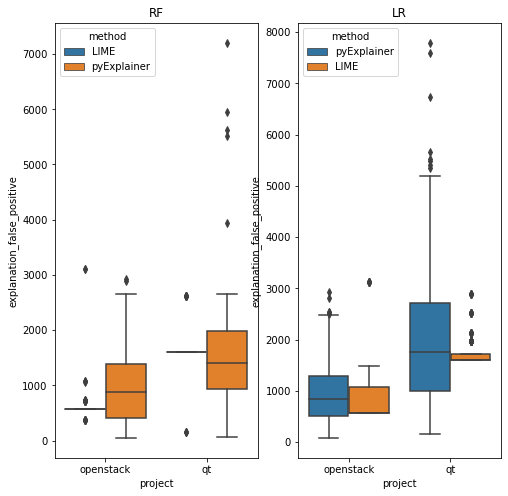

explanation_false_positive               \
                                                        count         mean   
global_model project   method                                                
LR           openstack LIME                             376.0   773.688830   
                       pyExplainer                      203.0   955.753695   
             qt        LIME                             254.0  1743.027559   
                       pyExplainer                      148.0  2087.358108   
RF           openstack LIME                             198.0   606.444444   
                       pyExplainer                      113.0   978.053097   
             qt        LIME                              48.0  1675.354167   
                       pyExplainer                       43.0  1822.837209   

                                                                         \
                                            std     min     25%     50%   
global_model project   method                                             
LR           openstack LIME          431.050248   572.0   572.0   572.0   
                       pyExplainer   592.380028    78.0   500.5   833.0   
             qt        LIME          306.535910  1595.0  1595.0  1595.0   
                       pyExplainer  1500.655181   154.0   993.5  1762.0   
RF           openstack LIME          268.053814   365.0   572.0   572.0   
                       pyExplainer   656.671053    46.0   405.0   883.0   
             qt        LIME          550.135553   158.0  1595.0  1595.0   
                       pyExplainer  1588.440729    69.0   931.0  1409.0   

                                                    
                                       75%     max  
global_model project   method                       
LR           openstack LIME         1082.0  3115.0  
                       pyExplainer  1291.0  2931.0  
             qt        LIME         1716.0  2895.0  
                       pyExplainer  2719.5  7794.0  
RF           openstack LIME          572.0  3115.0  
                       pyExplainer  1378.0  2921.0  
             qt        LIME         1595.0  2616.0  
                       pyExplainer  1978.5  7205.0

In [57]:
show_rq3_explanation_fp_eval_result()

In [238]:
def show_rq3_eval_result():

    openstack_rf = pd.read_csv('./eval_result/RQ3_openstack_RF.csv')
    qt_rf = pd.read_csv('./eval_result/RQ3_qt_RF.csv')
    result_rf = pd.concat([openstack_rf, qt_rf])
    result_rf['global_model'] = 'RF'
    
    openstack_lr = pd.read_csv('./eval_result/RQ3_openstack_LR.csv')
    qt_lr = pd.read_csv('./eval_result/RQ3_qt_LR.csv')
    result_lr = pd.concat([openstack_lr, qt_lr])
    result_lr['global_model'] = 'LR'
    
    all_result = pd.concat([result_rf, result_lr])

    my_pal = ['darkorange','blue']

    fig, axs = plt.subplots(2,2, figsize=(8,8))

    axs[0,0].set_title('RF')
    axs[0,1].set_title('LR')

    # plt.ylim(0,100)
    sns.boxplot(data=result_rf, x='project', y='true_positive_rate', hue='method', ax=axs[0,0], palette=['darkorange','royalblue'])
    sns.boxplot(data=result_rf, x='project', y='true_negative_rate', hue='method', ax=axs[1,0], palette=['darkorange','royalblue'])
    sns.boxplot(data=result_lr, x='project', y='true_positive_rate', hue='method', ax=axs[0,1], palette=['royalblue','darkorange'])
    sns.boxplot(data=result_lr, x='project', y='true_negative_rate', hue='method', ax=axs[1,1], palette=['royalblue','darkorange'])

    plt.show()
    
    display(all_result[['global_model', 'project','method', 'true_positive_rate','true_negative_rate']].groupby(['global_model','project','method']).describe())
    
    result_rf.to_csv('./eval_result/RQ3_RF.csv',index=False)
    result_lr.to_csv('./eval_result/RQ3_LR.csv',index=False)
    all_result.to_csv('./eval_result/RQ3.csv',index=False)
    
    fig.savefig('./eval_result/figures/RQ3.png')
    

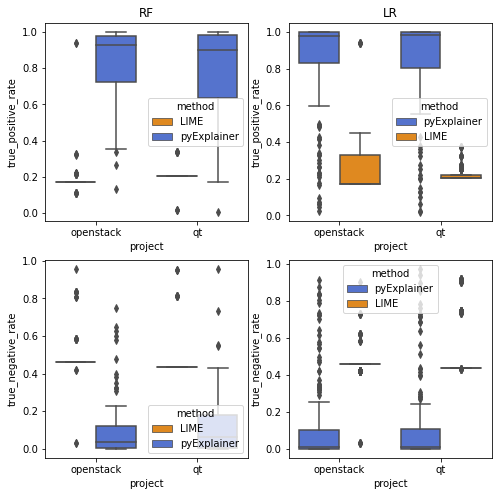

true_positive_rate                      \
                                                count      mean       std   
global_model project   method                                               
LR           openstack LIME                     376.0  0.232394  0.125684   
                       pyExplainer              202.0  0.852543  0.249859   
             qt        LIME                     254.0  0.223436  0.039294   
                       pyExplainer              148.0  0.846509  0.255501   
RF           openstack LIME                     198.0  0.182829  0.080812   
                       pyExplainer              113.0  0.839113  0.187810   
             qt        LIME                      48.0  0.214761  0.070521   
                       pyExplainer               43.0  0.771502  0.275514   

                                                                            \
                                         min       25%       50%       75%   
global_model project   method                                                
LR           openstack LIME         0.172445  0.172445  0.172445  0.326198   
                       pyExplainer  0.023515  0.831776  0.976937  1.000000   
             qt        LIME         0.204461  0.204461  0.204461  0.219972   
                       pyExplainer  0.019741  0.802237  0.983592  1.000000   
RF           openstack LIME         0.110039  0.172445  0.172445  0.172445   
                       pyExplainer  0.133253  0.723847  0.927344  0.979801   
             qt        LIME         0.020254  0.204461  0.204461  0.204461   
                       pyExplainer  0.008845  0.638123  0.898090  0.985386   

                                             true_negative_rate            \
                                         max              count      mean   
global_model project   method                                               
LR           openstack LIME         0.939102              376.0  0.456051   
                       pyExplainer  1.000000              202.0  0.116475   
             qt        LIME         0.371106              254.0  0.514201   
                       pyExplainer  1.000000              148.0  0.127640   
RF           openstack LIME         0.939102              198.0  0.486600   
                       pyExplainer  1.000000              113.0  0.100962   
             qt        LIME         0.335342               48.0  0.532300   
                       pyExplainer  1.000000               43.0  0.147841   

                                                                            \
                                         std       min       25%       50%   
global_model project   method                                                
LR           openstack LIME         0.080481  0.030960  0.459752  0.459752   
                       pyExplainer  0.214088  0.000000  0.000000  0.011610   
             qt        LIME         0.154259  0.430672  0.436975  0.436975   
                       pyExplainer  0.235930  0.000000  0.000000  0.008403   
RF           openstack LIME         0.106922  0.030960  0.459752  0.459752   
                       pyExplainer  0.154585  0.000000  0.006192  0.035604   
             qt        LIME         0.179187  0.436975  0.436975  0.436975   
                       pyExplainer  0.218619  0.000000  0.002101  0.065126   

                                                        
                                         75%       max  
global_model project   method                           
LR           openstack LIME         0.459752  0.899381  
                       pyExplainer  0.103715  0.911765  
             qt        LIME         0.436975  0.918067  
                       pyExplainer  0.105567  0.970588  
RF           openstack LIME         0.459752  0.955108  
                       pyExplainer  0.119195  0.750774  
             qt        LIME         0.436975  0.953782  
                       pyExplainer  0.178571  0.955

In [239]:
show_rq3_eval_result()

In [61]:
## use inverse rule to predict train/test clean instance
def rq3_get_guidance(proj_name, global_model_name):
    global_model_name = global_model_name.upper()
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name)

    commit_id_list = '''7b64653931628328bd5d70b0cdea8952e6c709f8
be23b19905a9e500fa4b14c43b9492f4b43e9828
848ef0043f60795db680afe8f67b633459eaf52c
608c67439c8fcfa1a2fddd1087ca1fe998a8f9fd
607acb33be18f0e508329f3c8514061322d294a9
2bfc7171c23d0595aa7f8680271778bc58cb28ba
9bc29208bda6071a34bcc0da36a396eb8bab4f30
10c5c93925abe3d34c4430e0ed852d8358fb2353
d72848c9afba40d21235a4e95cf8e69549290dca
f4b78c7f17e29448ed54b136eeb4ac700b324120
0eb7e35fbfe5de5f9f00ff1a0cce1d6a61f3a902
8e575be75c80ea71a6ad8fb73e6ace1ed708938f
9928edb42da42af3463d4a989a0797be46198908
1724c5cee71d3b32466dd9d6cabd22a3339546b4
874e272a56d314a6fb1bd98e7ecd7f986f3b3898
fc27c5e3df4b047f2da31e6217e36936b331093f
1a40831f1711bf46c878dd247679bb05d19ffb5a
41e3a94ae18a9219ff4ab10389f3a7799c9b6493
b0306a93645ea6475a2bc045d8fc8bc4bd6f00a5
1d6235cc3fb3c7806c2c4671f1c5b03022136008
486e10d3740301b417e2a972ec7c797f562e75be'''.split('\n')
    
#     print(commit_id_list)
    
    py_exp_guidance = pd.DataFrame()
    
    for commit in commit_id_list:
        exp_obj = pickle.load(open(pyExp_dir+proj_name+'_'+global_model_name+'_all_explainer_'+commit+'.pkl','rb'))
        py_exp = exp_obj['pyExplainer']
        
        py_exp_local_model = py_exp['local_model']
        
        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
        py_exp_flip_rule = flip_rule(py_exp_the_best_defective_rule_str)
        
        py_exp_guidance = py_exp_guidance.append(pd.Series([proj_name,commit, '', 
                                                            py_exp_the_best_defective_rule_str, py_exp_flip_rule]),
                                                ignore_index=True)
        
    py_exp_guidance.columns = ['system','commitID','repoName','explanation','guidance']
    py_exp_guidance.to_csv('./guidance_table/'+proj_name+'_'+global_model_name+'_pyExplainer_guidance.csv',index=False)
    
#     for i in range(0,len(feature_df)):
#         X_explain = feature_df.iloc[[i]]

#         row_index = str(X_explain.index[0])

#         exp_obj = pickle.load(open(pyExp_dir+proj_name+'_'+global_model_name+'_all_explainer_'+row_index+'.pkl','rb'))
#         py_exp = exp_obj['pyExplainer']
#         lime_exp = exp_obj['LIME']

#         py_exp_local_model = py_exp['local_model']
#         lime_exp_local_model = lime_exp['local_model']
        
#         py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
        
#         lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]

#         py_exp_pred = eval_rule(py_exp_the_best_defective_rule_str, X_explain)[0]
#         lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

#         # system(qt/openstack), commitID, repoName, explanation, guidance
        
#         if py_exp_pred:
#             py_exp_flip_rule = flip_rule(py_exp_the_best_defective_rule_str)
#             found_commit_id.append(row_index)
# #             repo_of_commit = commit_repo_dict[row_index]
# #             py_exp_guidance = py_exp_guidance.append(pd.Series([proj_name, row_index, repo_of_commit, 
# #                                                                 py_exp_the_best_defective_rule_str, py_exp_flip_rule]))
# #             break
        
#         if lime_pred:
#             lime_flip_rule = flip_rule(lime_the_best_defective_rule_str)
#             found_commit_id.append(row_index)
#             repo_of_commit = commit_repo_dict[row_index]
#             lime_guidance = lime_guidance.append(pd.Series([proj_name, row_index, repo_of_commit, 
#                                                             lime_the_best_defective_rule_str, lime_flip_rule]))
#             break

#         print('finished {} from {} commits'.format(str(i+1),len(feature_df)))
        
# #         break
        
#     print('finished RQ3 of',proj_name)
    
#     py_exp_guidance.columns = ['system','commitID','repoName','explanation','guidance']
#     lime_guidance.columns = ['system','commitID','repoName','explanation','guidance']
    
#     py_exp_guidance.to_csv('./guidance_table/'+proj_name+'_'+global_model_name+'_pyExplainer_guidance.csv',index=False)
#     lime_guidance.to_csv('./guidance_table/'+proj_name+'_'+global_model_name+'_LIME_guidance.csv',index=False)
    
#     print(len(set(found_commit_id)-set(commit_hash_list)))
#     print(len(commit_hash_list))
    print('finished')
    
#     return set(found_commit_id)

In [62]:
set_rf = rq3_get_guidance('openstack','rf')

finished


In [52]:
set_lr = rq3_get_guidance('openstack','lr')

finished


In [32]:
def get_sample_rules(proj_name, global_model_name):
    global_model_name = global_model_name.upper()
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name)

    commit_id_list = '''608c67439c8fcfa1a2fddd1087ca1fe998a8f9fd
2bfc7171c23d0595aa7f8680271778bc58cb28ba
b0306a93645ea6475a2bc045d8fc8bc4bd6f00a5
10c5c93925abe3d34c4430e0ed852d8358fb2353
7b64653931628328bd5d70b0cdea8952e6c709f8
be23b19905a9e500fa4b14c43b9492f4b43e9828
848ef0043f60795db680afe8f67b633459eaf52c
607acb33be18f0e508329f3c8514061322d294a9
9bc29208bda6071a34bcc0da36a396eb8bab4f30
d72848c9afba40d21235a4e95cf8e69549290dca
f4b78c7f17e29448ed54b136eeb4ac700b324120
0eb7e35fbfe5de5f9f00ff1a0cce1d6a61f3a902
8e575be75c80ea71a6ad8fb73e6ace1ed708938f
9928edb42da42af3463d4a989a0797be46198908
1724c5cee71d3b32466dd9d6cabd22a3339546b4
874e272a56d314a6fb1bd98e7ecd7f986f3b3898
fc27c5e3df4b047f2da31e6217e36936b331093f
1a40831f1711bf46c878dd247679bb05d19ffb5a
41e3a94ae18a9219ff4ab10389f3a7799c9b6493
1d6235cc3fb3c7806c2c4671f1c5b03022136008
486e10d3740301b417e2a972ec7c797f562e75be'''.split('\n')
    
#     print(commit_id_list)
    
    py_exp_guidance = pd.DataFrame()
    
    for commit in commit_id_list:
        exp_obj = pickle.load(open(pyExp_dir+proj_name+'_'+global_model_name+'_all_explainer_'+commit+'.pkl','rb'))
        py_exp = exp_obj['pyExplainer']
        
        py_exp_local_model = py_exp['local_model']
        
        rule_df = py_exp_local_model.get_rules()
#     print(rule_df)
        top_k = 10
        top_k_positive_rules = rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("importance", ascending=False).head(top_k)
    
        display(top_k_positive_rules)
        display(list(top_k_positive_rules['rule']))
        break
#         py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
#         py_exp_flip_rule = flip_rule(py_exp_the_best_defective_rule_str)
        
#         py_exp_guidance = py_exp_guidance.append(pd.Series([proj_name,commit, '', 
#                                                             py_exp_the_best_defective_rule_str, py_exp_flip_rule]),
#                                                 ignore_index=True)

In [33]:
get_sample_rules('openstack','rf')

,rule,type,coef,support,importance
330,ndev > 127.18500137329102 & ent <= 1.004999995...,rule,0.488276,0.517241,0.243993
828,nrev > 7.184999942779541 & age <= 13.360000133...,rule,0.481389,0.557029,0.239124
754,nd <= 5.610000133514404 & ent > 0.824999988079...,rule,0.570549,0.201592,0.228898
1108,ndev > 114.02499771118164 & asawr <= 0.0349999...,rule,0.482641,0.339523,0.228554
145,la > 117.33499908447266 & ent > 0.335000008344...,rule,0.433971,0.474801,0.216710
1216,rrexp <= 1013.7949829101562,rule,0.512157,0.230769,0.215785
1231,rrexp > 974.0050048828125 & nrev <= 11.6849999...,rule,0.458773,0.328912,0.215540
1804,la > 18.61500072479248 & ndev <= 183.964996337...,rule,0.434740,0.572944,0.215044
60,la <= 51.85500144958496,rule,0.442330,0.270557,0.196504
1277,rrexp <= 1659.5449829101562 & app <= 2.0049999...,rule,0.456837,0.236074,0.194004


['ndev > 127.18500137329102 & ent <= 1.0049999952316284 & la > 8.34000015258789',
 'nrev > 7.184999942779541 & age <= 13.360000133514404 & rrexp > 1159.6649780273438',
 'nd <= 5.610000133514404 & ent > 0.824999988079071 & la > 32.94499969482422',
 'ndev > 114.02499771118164 & asawr <= 0.03499999921768904',
 'la > 117.33499908447266 & ent > 0.33500000834465027',
 'rrexp <= 1013.7949829101562',
 'rrexp > 974.0050048828125 & nrev <= 11.684999942779541 & ndev <= 190.7300033569336',
 'la > 18.61500072479248 & ndev <= 183.96499633789062 & ndev > 113.75',
 'la <= 51.85500144958496',
 'rrexp <= 1659.5449829101562 & app <= 2.0049999952316284 & ndev <= 168.15499877929688']

# Test pyExplainer visualization

In [4]:
proj_name = 'openstack'
global_model_name = 'RF'

x_train, y_train = prepare_data(proj_name, mode = 'train')
global_model = pickle.load(open(proj_name+'_'+global_model_name+'_global_model.pkl','rb'))
indep = x_train.columns
dep = 'defect'
class_label = ['clean', 'defect']

pyExp = PyExplainer(x_train, y_train, indep, dep, global_model, class_label)

In [5]:
exp_obj = pickle.load(open(pyExp_dir+proj_name+'_'+global_model_name+'_all_explainer_'+'34a208d1f3829173815beca81d07b53633a12989'+'.pkl','rb'))

In [6]:
# print(exp_obj['pyExplainer'].keys())
pyexp_obj = exp_obj['pyExplainer']
pyExp.visualise(pyexp_obj)

AttributeError: 'DataFrame' object has no attribute '_data'